# Result Exploration
This notebook helps to build functions for printing results of CNN training. 

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from IPython.display import display
from IPython.display import display_html
import shutil

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Scripts import Print_Functions as PF
from Scripts import Centralized_Pain as painCNN
from Scripts import Data_Loader_Functions as DL

FIGURES = os.path.join(module_path, "Figures")
RESULTS = os.path.join(module_path, "Results")
DATA = os.path.join(module_path, "Data", "Augmented Data", "Flexible Augmentation")

## Prepare Plots for Aggregate Metrics

In [2]:
# Define variables
model_type = 'Centralized'
data_type = 'Sessions'

centralized_path = os.path.join(module_path, 'Models', 'Pain', 'Centralized', 'Final', data_type)
centralized_model_paths = sorted([os.path.join(centralized_path, path) for path in os.listdir(centralized_path) if 'shard-0.00' in path])
federated_path = os.path.join(module_path, 'Models', 'Pain', 'Federated', 'Final', data_type)
federated_model_paths = sorted([os.path.join(federated_path, path) for path in os.listdir(federated_path) if 'shard-0.00' in path])
model_paths = centralized_model_paths if model_type == 'Centralized' else federated_model_paths

### Step 0: Create Baseline Metrics

In [ ]:
# Load and prepare data
if data_type == 'Sessions':
    test_path = os.path.join(DATA, "group_2")
    df = DL.create_pain_df(test_path)
    df_test = df[(df['Trans_1'] == 'original') & (df['Trans_2'] == 'straight')]
else:
    test_path = os.path.join(DATA, "group_2_test")
    test_data, test_labels = DL.load_pain_data(test_path)
    test_labels_binary = DL.reduce_pain_label_categories(test_labels[:, 4].astype(int), 1)
    enc = OneHotEncoder(sparse=False, categories='auto')
    test_labels_binary = enc.fit_transform(test_labels_binary.reshape(len(test_labels_binary), 1))
    people = test_labels[:, 0].astype(int)

In [ ]:
# Load model
print(model_paths[-1])
model = tf.keras.models.load_model(model_paths[-1])

In [ ]:
# Make predictions
loss = tf.keras.losses.BinaryCrossentropy()

if data_type is not 'Sessions':
    df_history = painCNN.evaluate_pain_cnn(model, 0, test_data, test_labels_binary, history=None, people=people, loss=loss)
else:
    df_history = painCNN.evaluate_pain_cnn(model, 0, test_data=None, test_labels=None, df=df_test, history=None, people=None, loss=loss, session=True)
df_history['Shard'] = 0.00

In [ ]:
# Save predictions to file
baseline_path = os.path.join(RESULTS, 'Final', data_type, '2019-08-06_PAIN_0-' + data_type.lower() + "-" + model_type + '-Baseline')
if not os.path.isdir(baseline_path):
    os.mkdir(baseline_path)

file = time.strftime("%Y-%m-%d-%H%M%S") + "_PAIN_" + data_type.lower() + "-" + model_type + ".csv"
df_history.to_csv(os.path.join(baseline_path, file))

### Step 1: Set parameters

In [3]:
# Set variable to plot
current_metric = 'Accuracy'
# current_metric = 'Precision'
# current_metric = 'Recall'
# current_metric = 'F1_Score'
# current_metric = 'Avg. Precision'

In [4]:
# Set experiment filter
criteria = '-sessions'
date = '2019-08-08'

### Step 2: Get relevant folders

In [48]:
# Get all paths in Final Results folder
final_results = os.path.join(RESULTS, 'Final', data_type)
final_results_folders = sorted([os.path.join(final_results, path) for path in os.listdir(final_results)])

In [49]:
# Filter paths for relevant experiments
final_results_folders = [folder for folder in final_results_folders if criteria in folder and date in folder]

In [ ]:
# Concatenate results
for folder in final_results_folders:
    if 'Baseline' not in folder:
        df_concat = None
        for file in sorted(os.listdir(folder)):
            if 'shard-0.00' not in file and file[0] != '.':
                df = pd.read_csv(os.path.join(folder, file))
                df['Shard'] = file.split('_shard-')[1].split('_')[0]
                if df_concat is None:
                    df_concat = pd.DataFrame(columns=df.columns)
                df_concat = pd.concat((df_concat, df), ignore_index=True, sort=False)
        df_concat.drop('Unnamed: 0', axis=1, inplace=True)
        f_path = os.path.join(os.path.dirname(folder), time.strftime("%Y-%m-%d")+ '_' + file.split("PAIN_")[1].split('_shard')[0] + "_CONCATENATED.csv")
        df_concat.to_csv(f_path)
    shutil.rmtree(folder)

In [177]:
df = pd.read_csv('/Users/nico/PycharmProjects/FederatedLearning/Results/Final/Sessions/2019-08-09_5-sessions-Federated-federated-pre-training_CONCATENATED.csv', index_col=0)

In [185]:
for i in range(0,5):
    df_new = df[i * len(df) // 5 : (i + 1) * len(df) // 5]
    df_new.to_csv('/Users/nico/PycharmProjects/FederatedLearning/Results/Final/Sessions/{}.csv'.format(i))

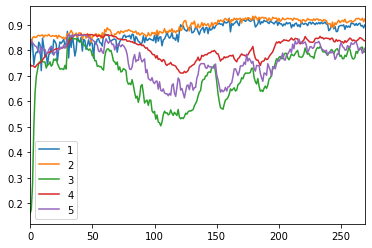

In [194]:
results = os.path.join(RESULTS, 'Final', 'Sessions')
metric = 'Aggregate Accuracy'
files = sorted([file for file in os.listdir(results) if os.path.splitext(file)[1] == '.csv'])
dfs = []
for file in files:
    df = pd.read_csv(os.path.join(results, file))
    df[df['Shard'] == df['Session'] - 1][[metric, 'Session', 'Epoch']].drop_duplicates().reset_index()[metric].plot()
plt.legend([1,2,3,4,5])

/Users/nico/PycharmProjects/FederatedLearning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


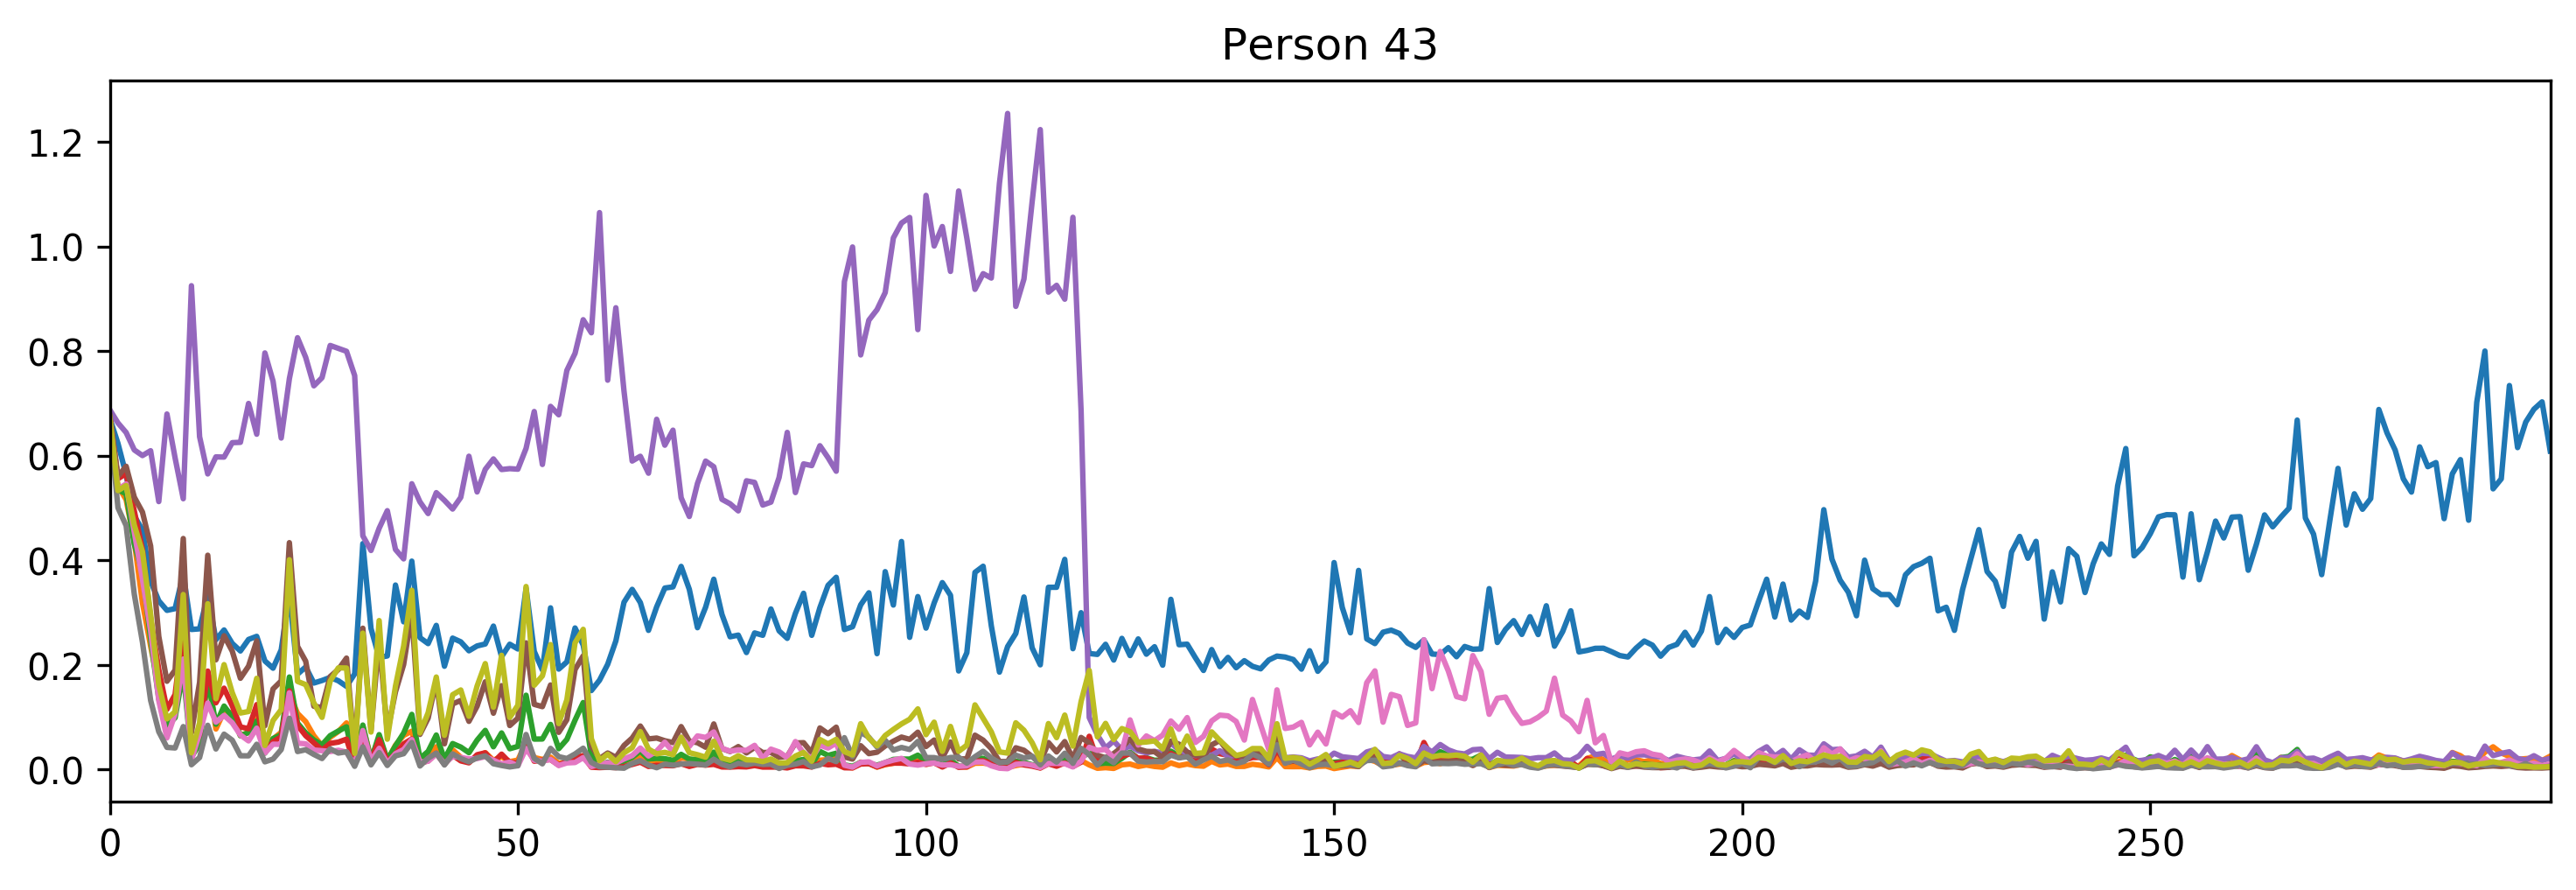

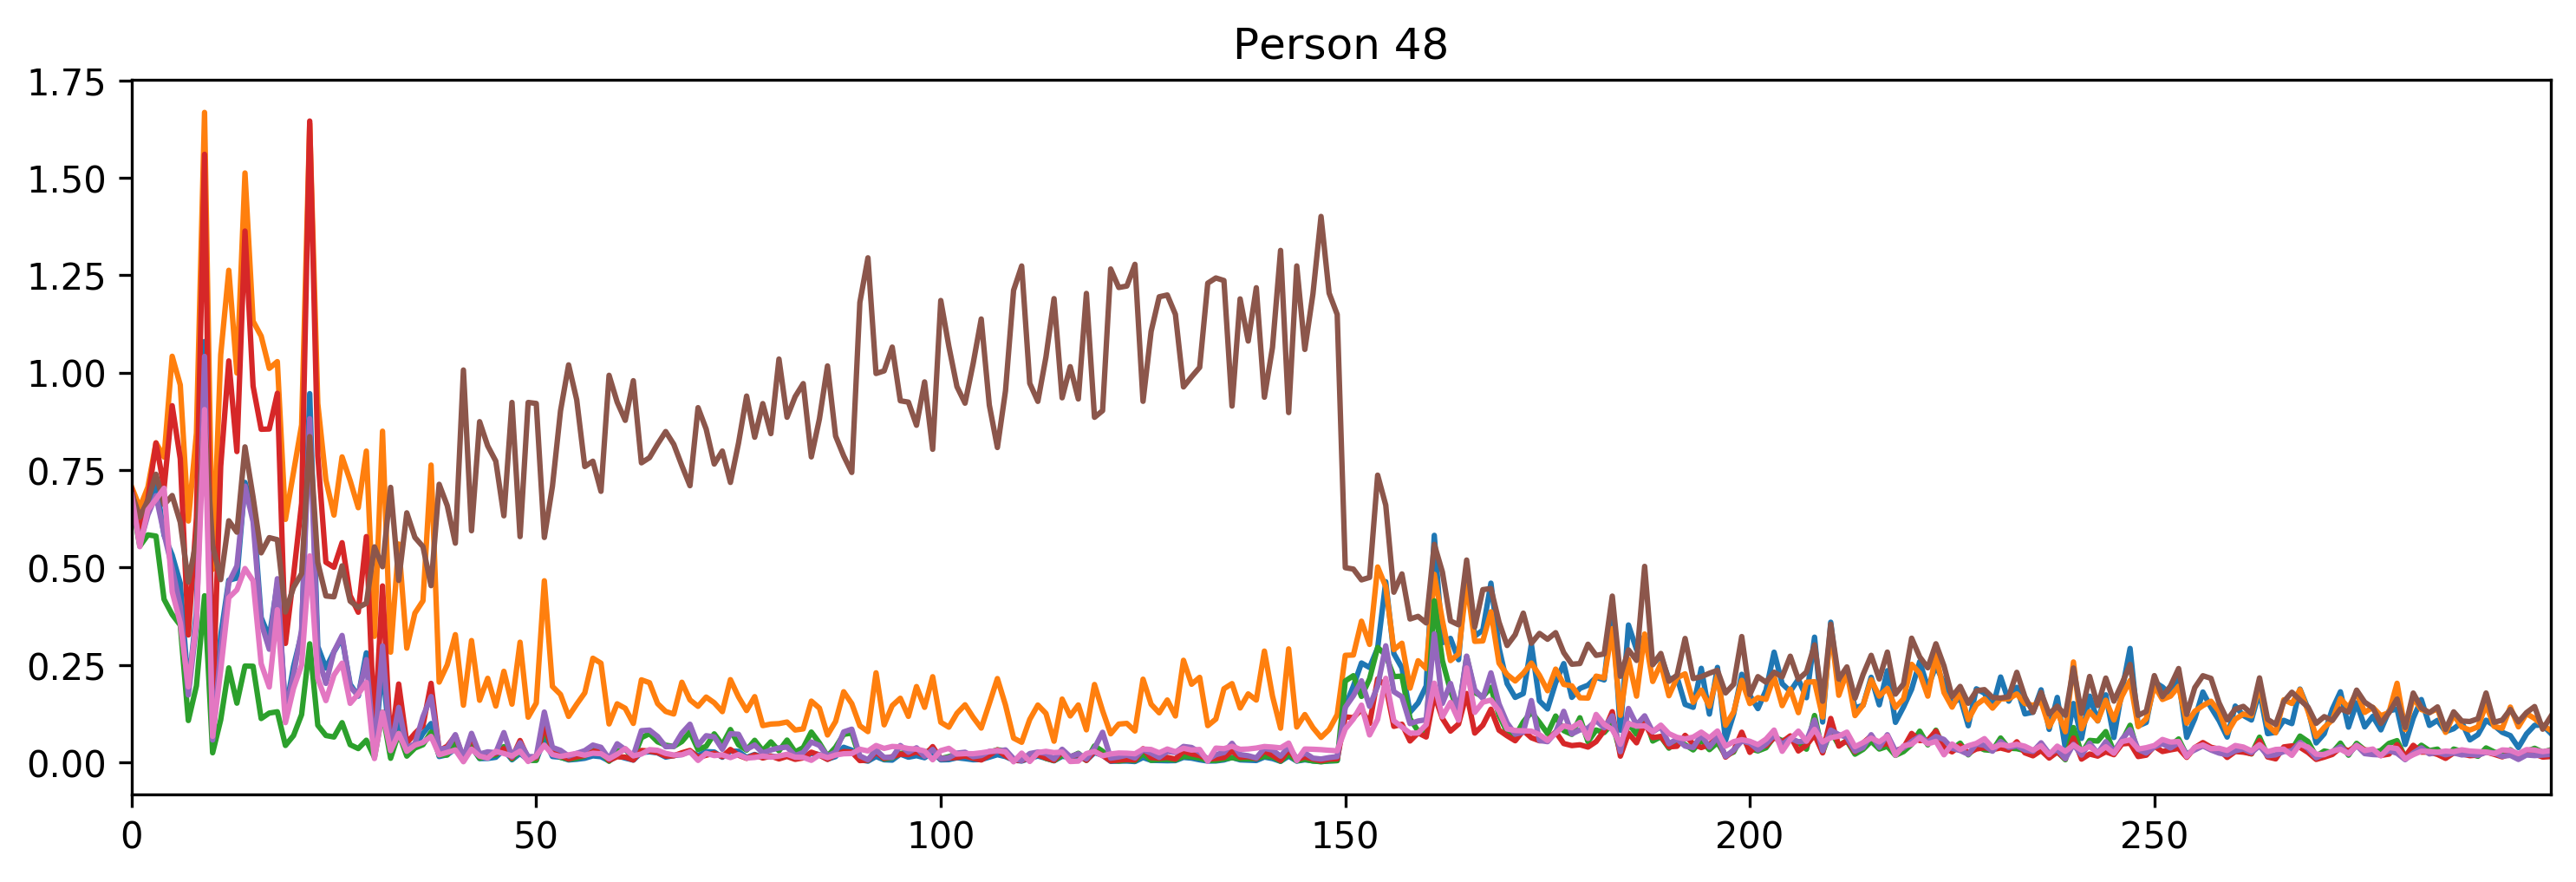

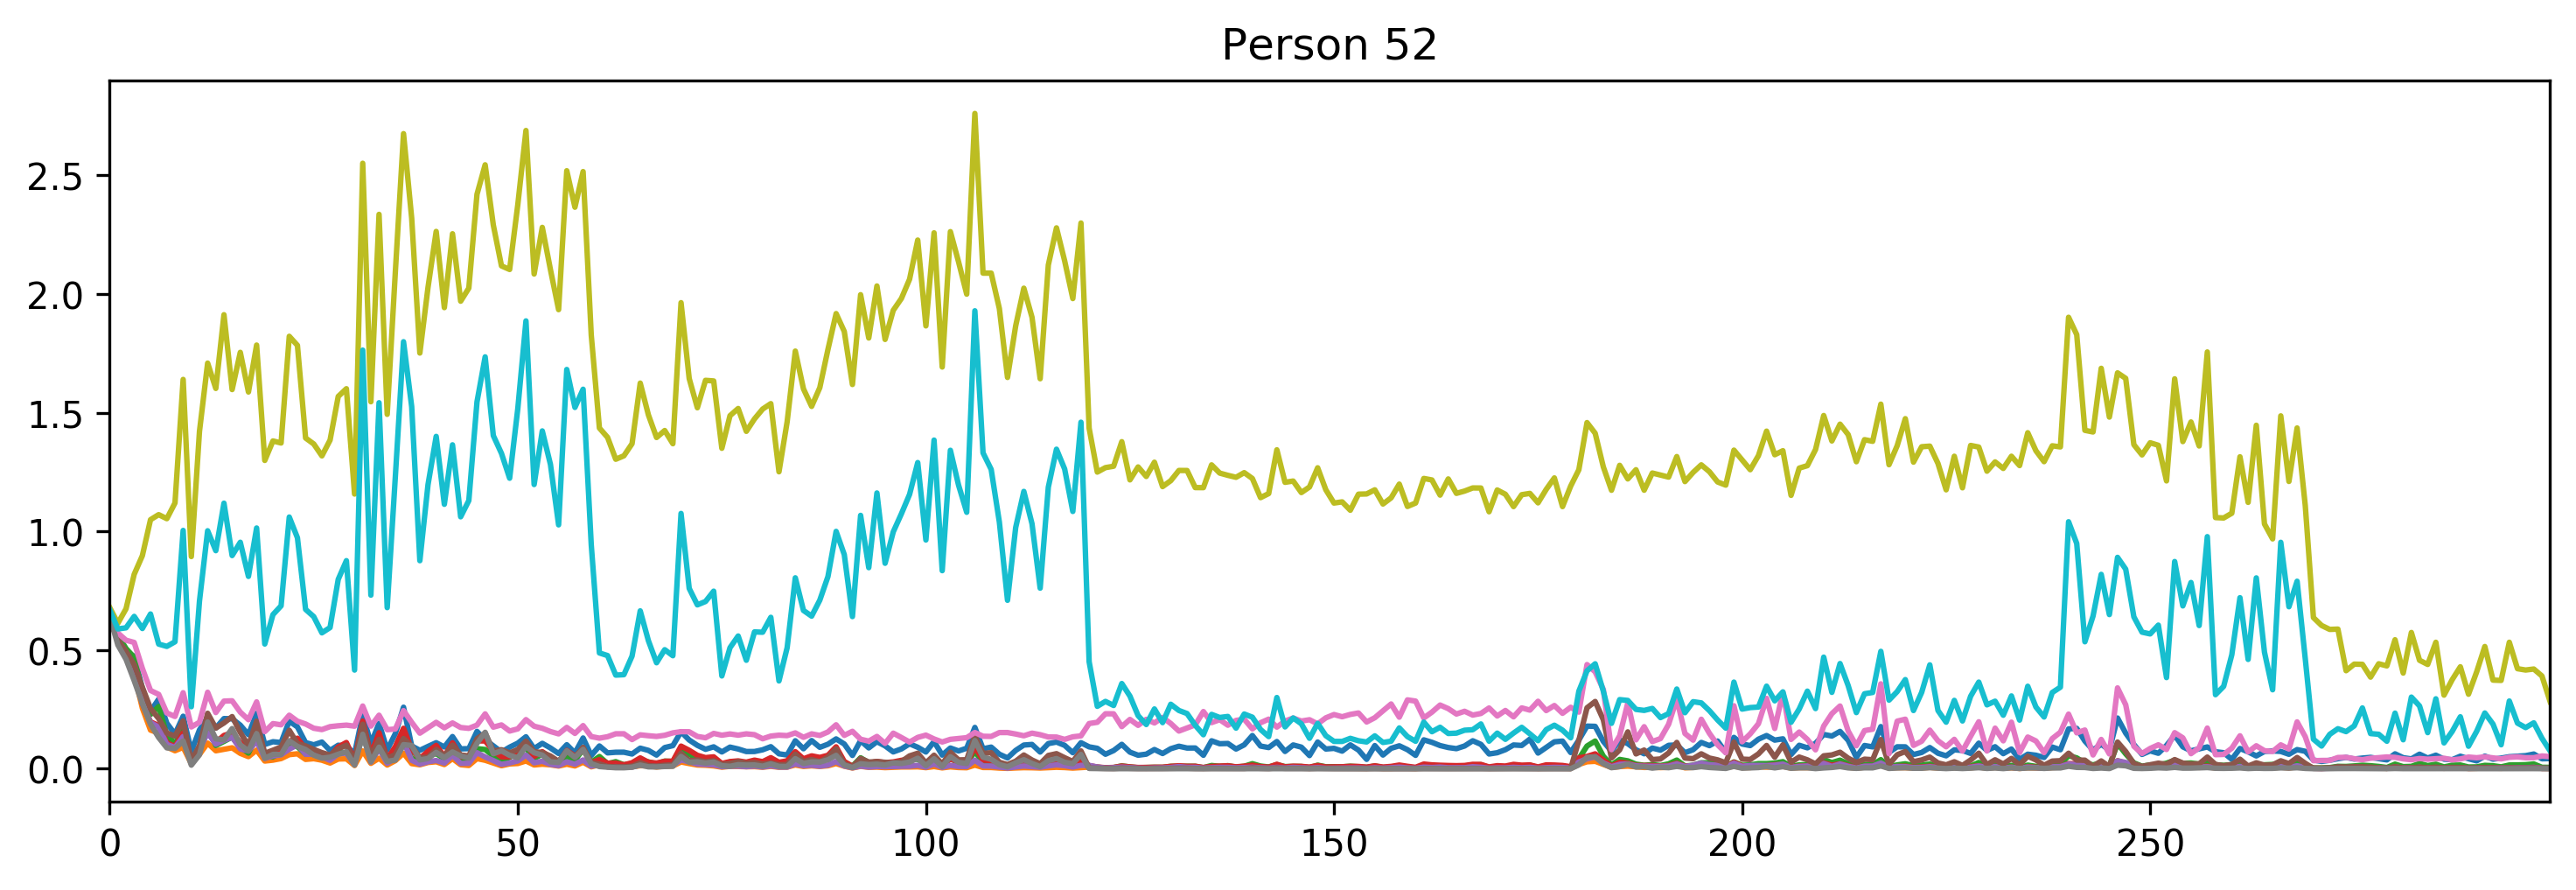

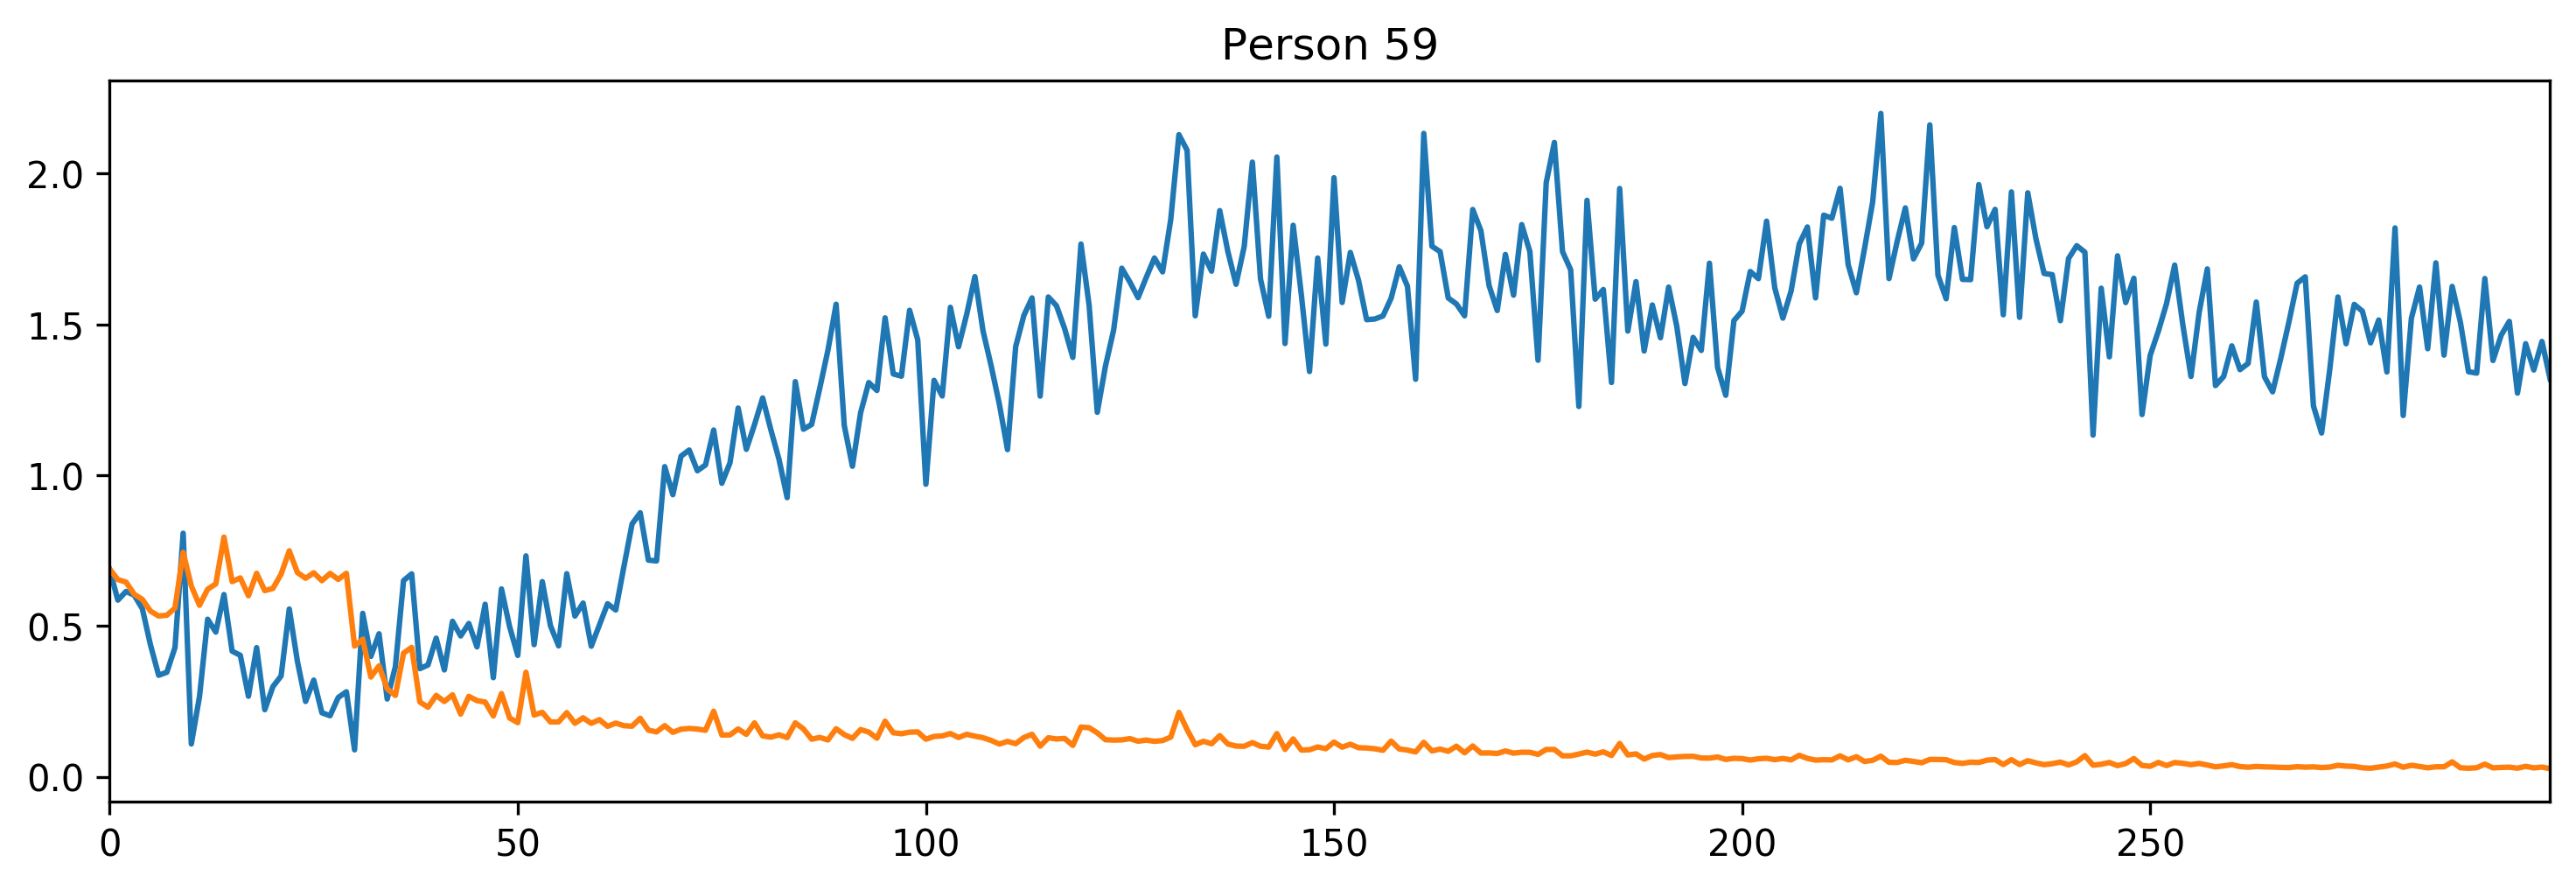

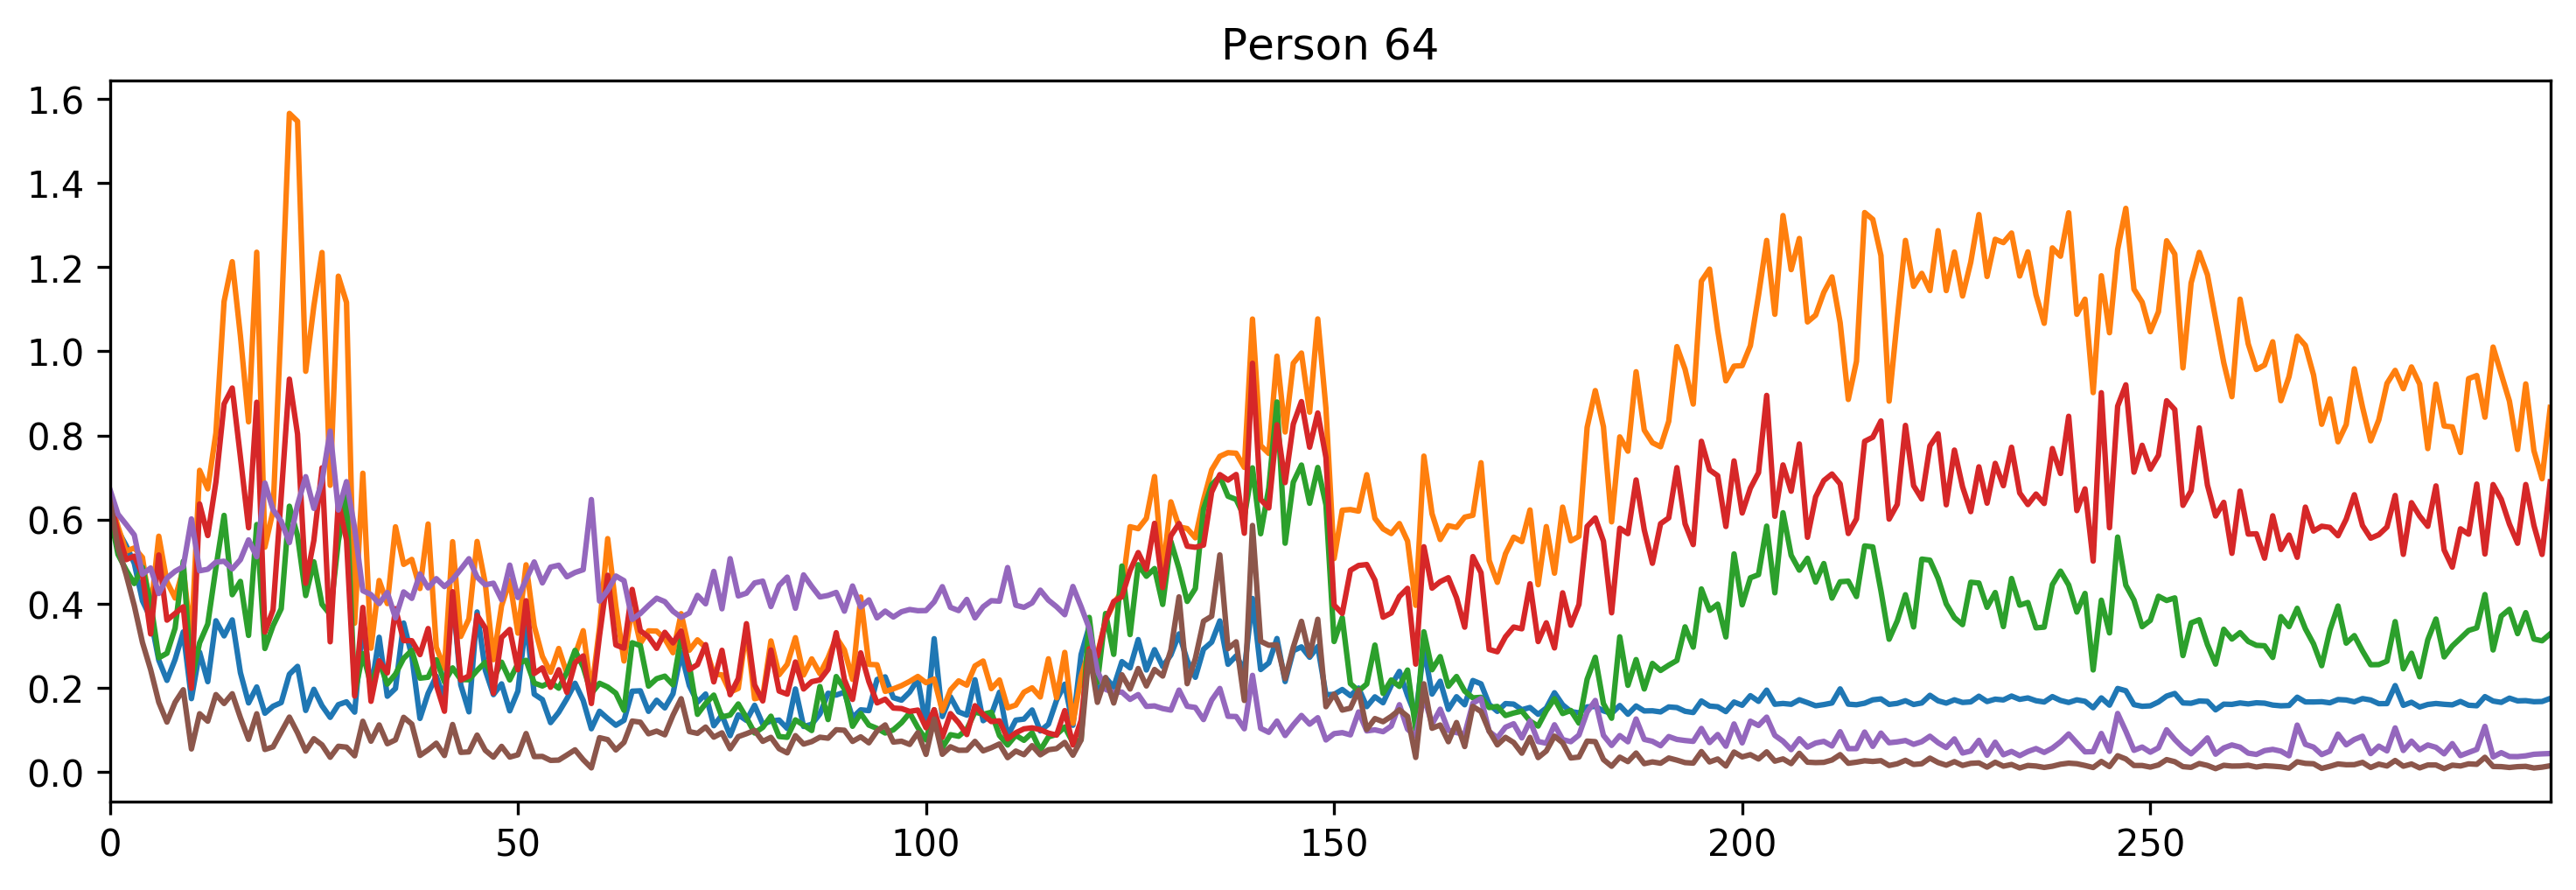

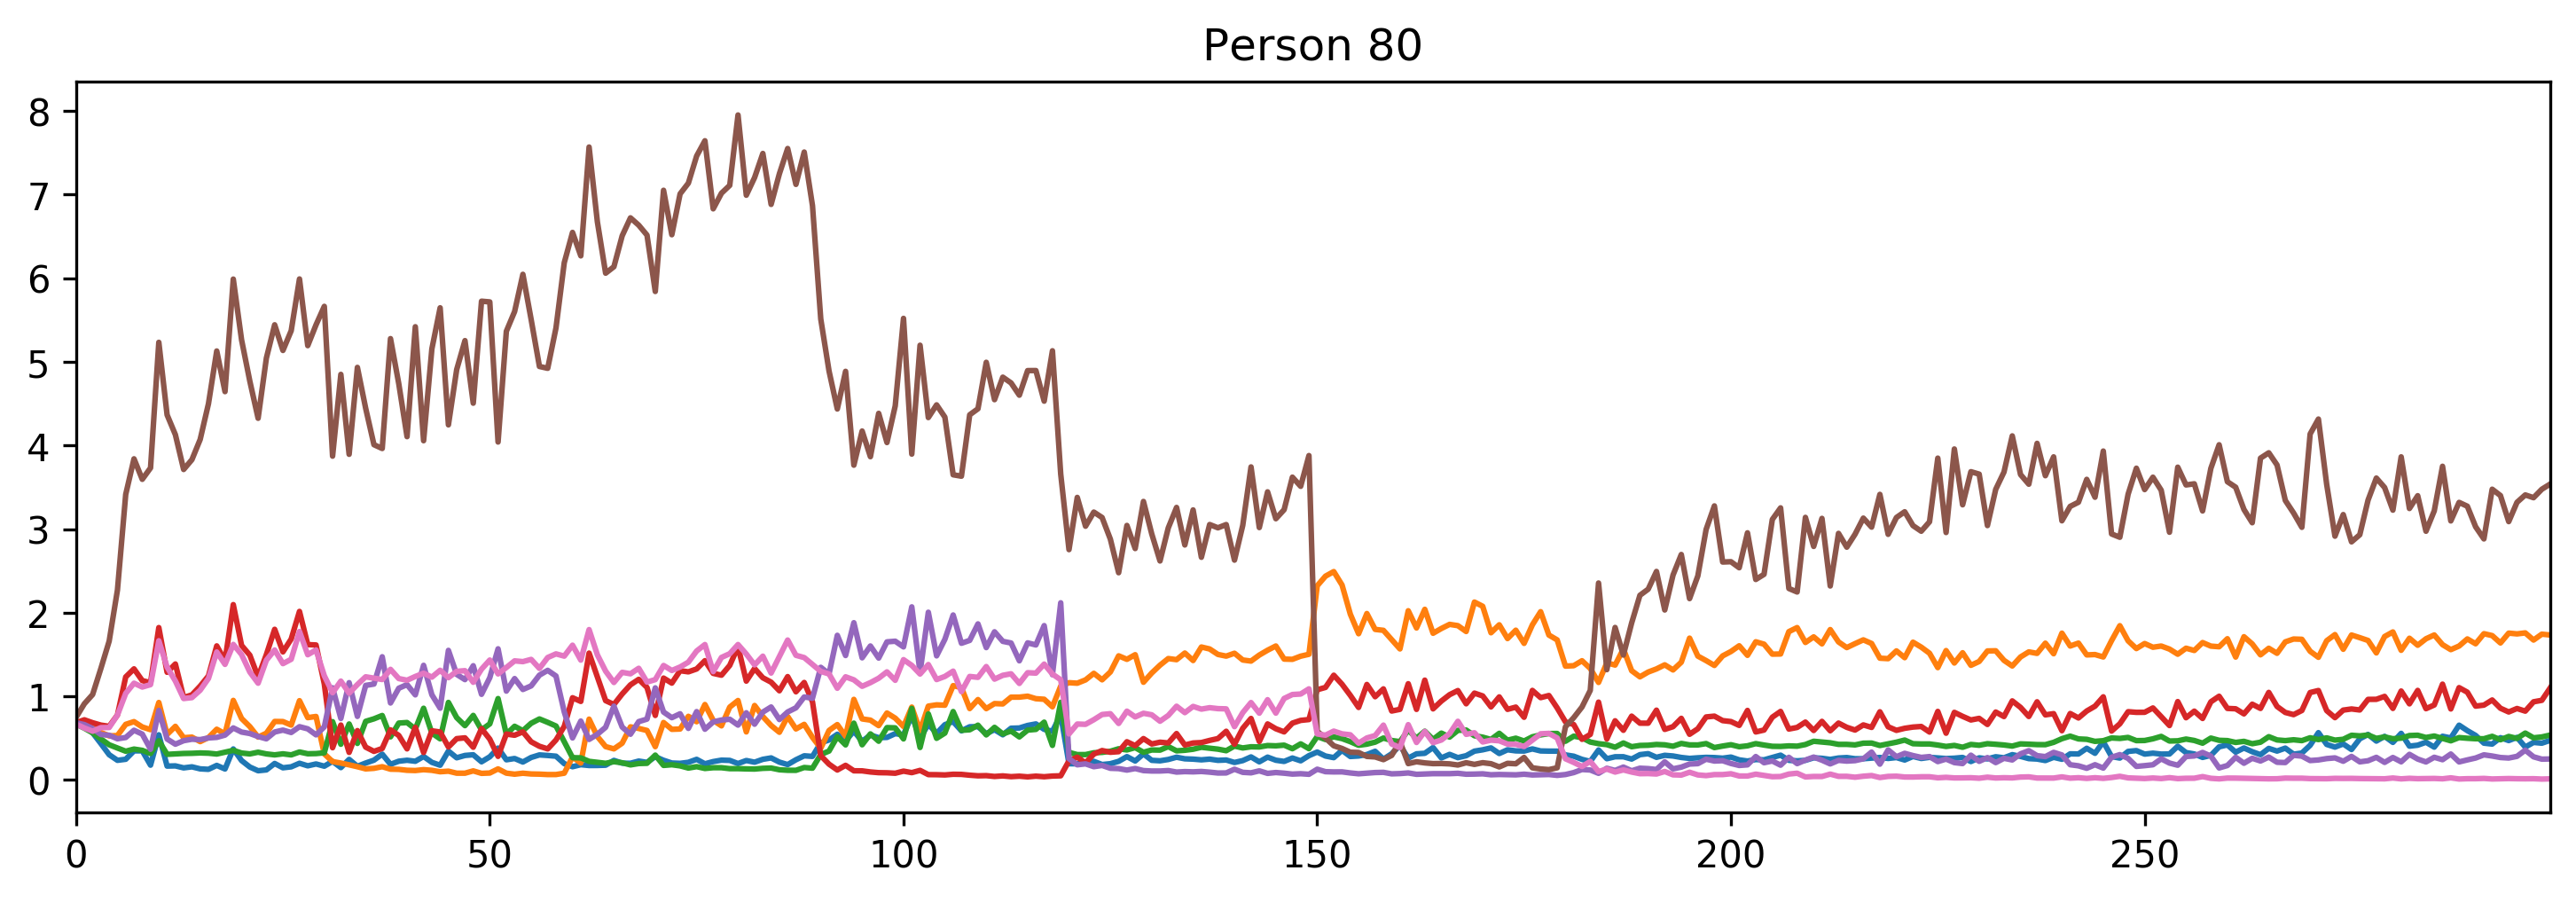

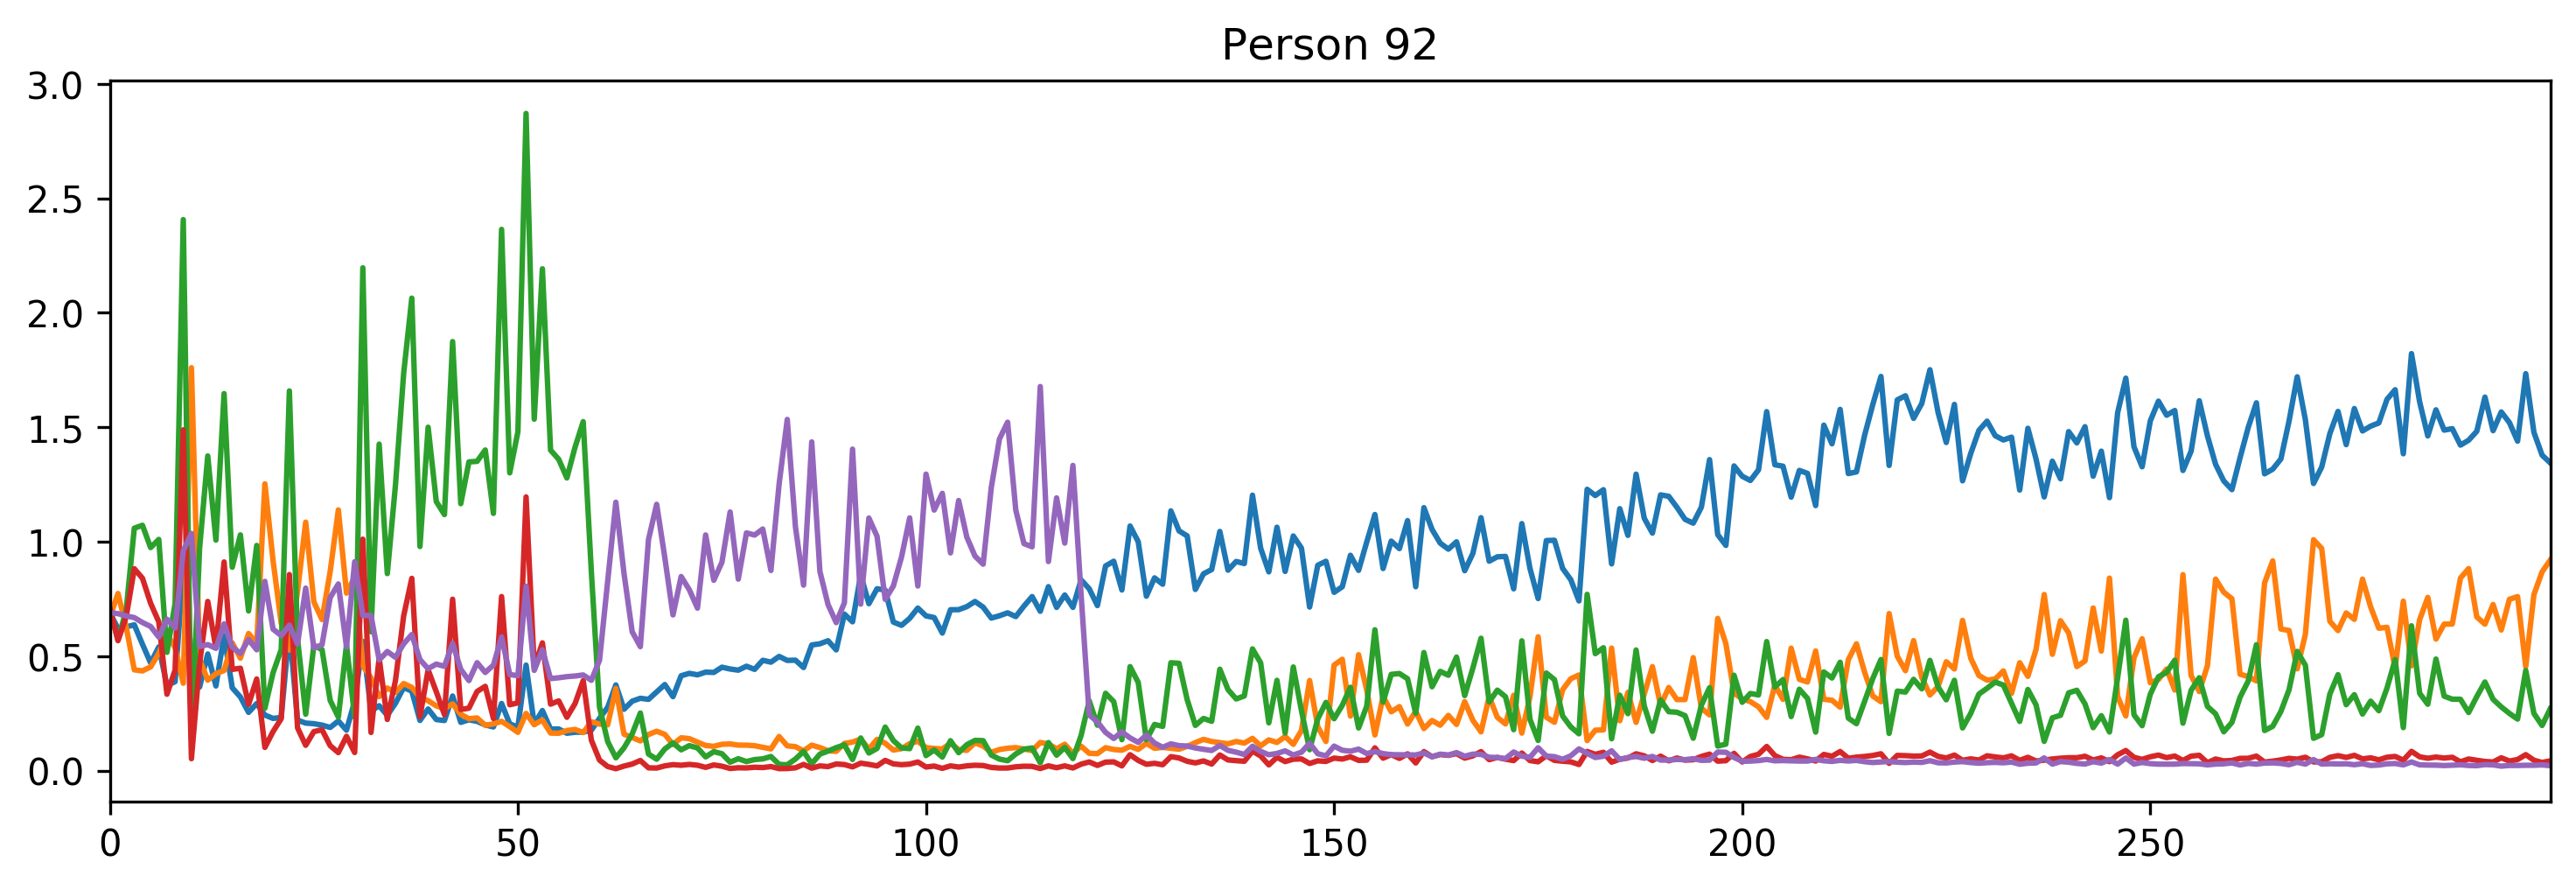

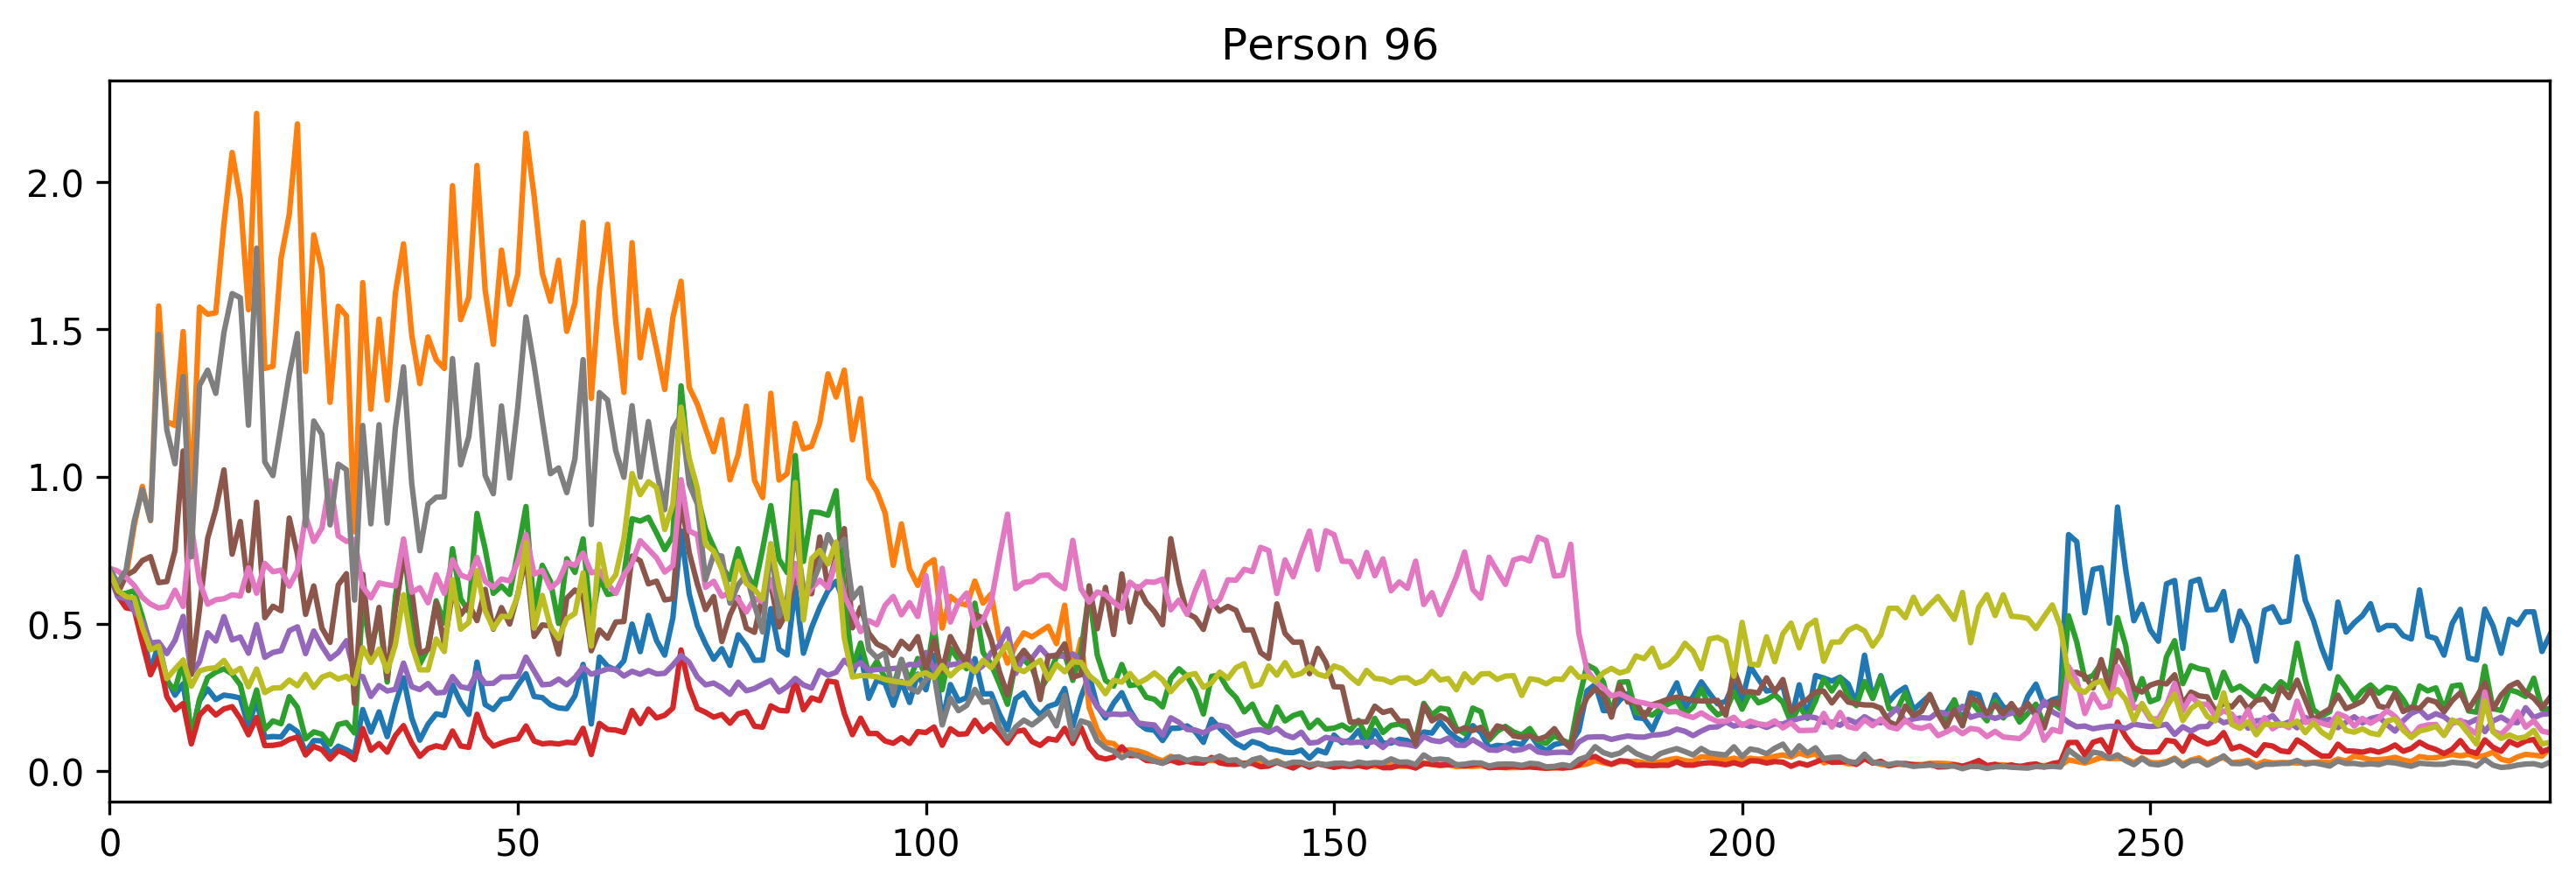

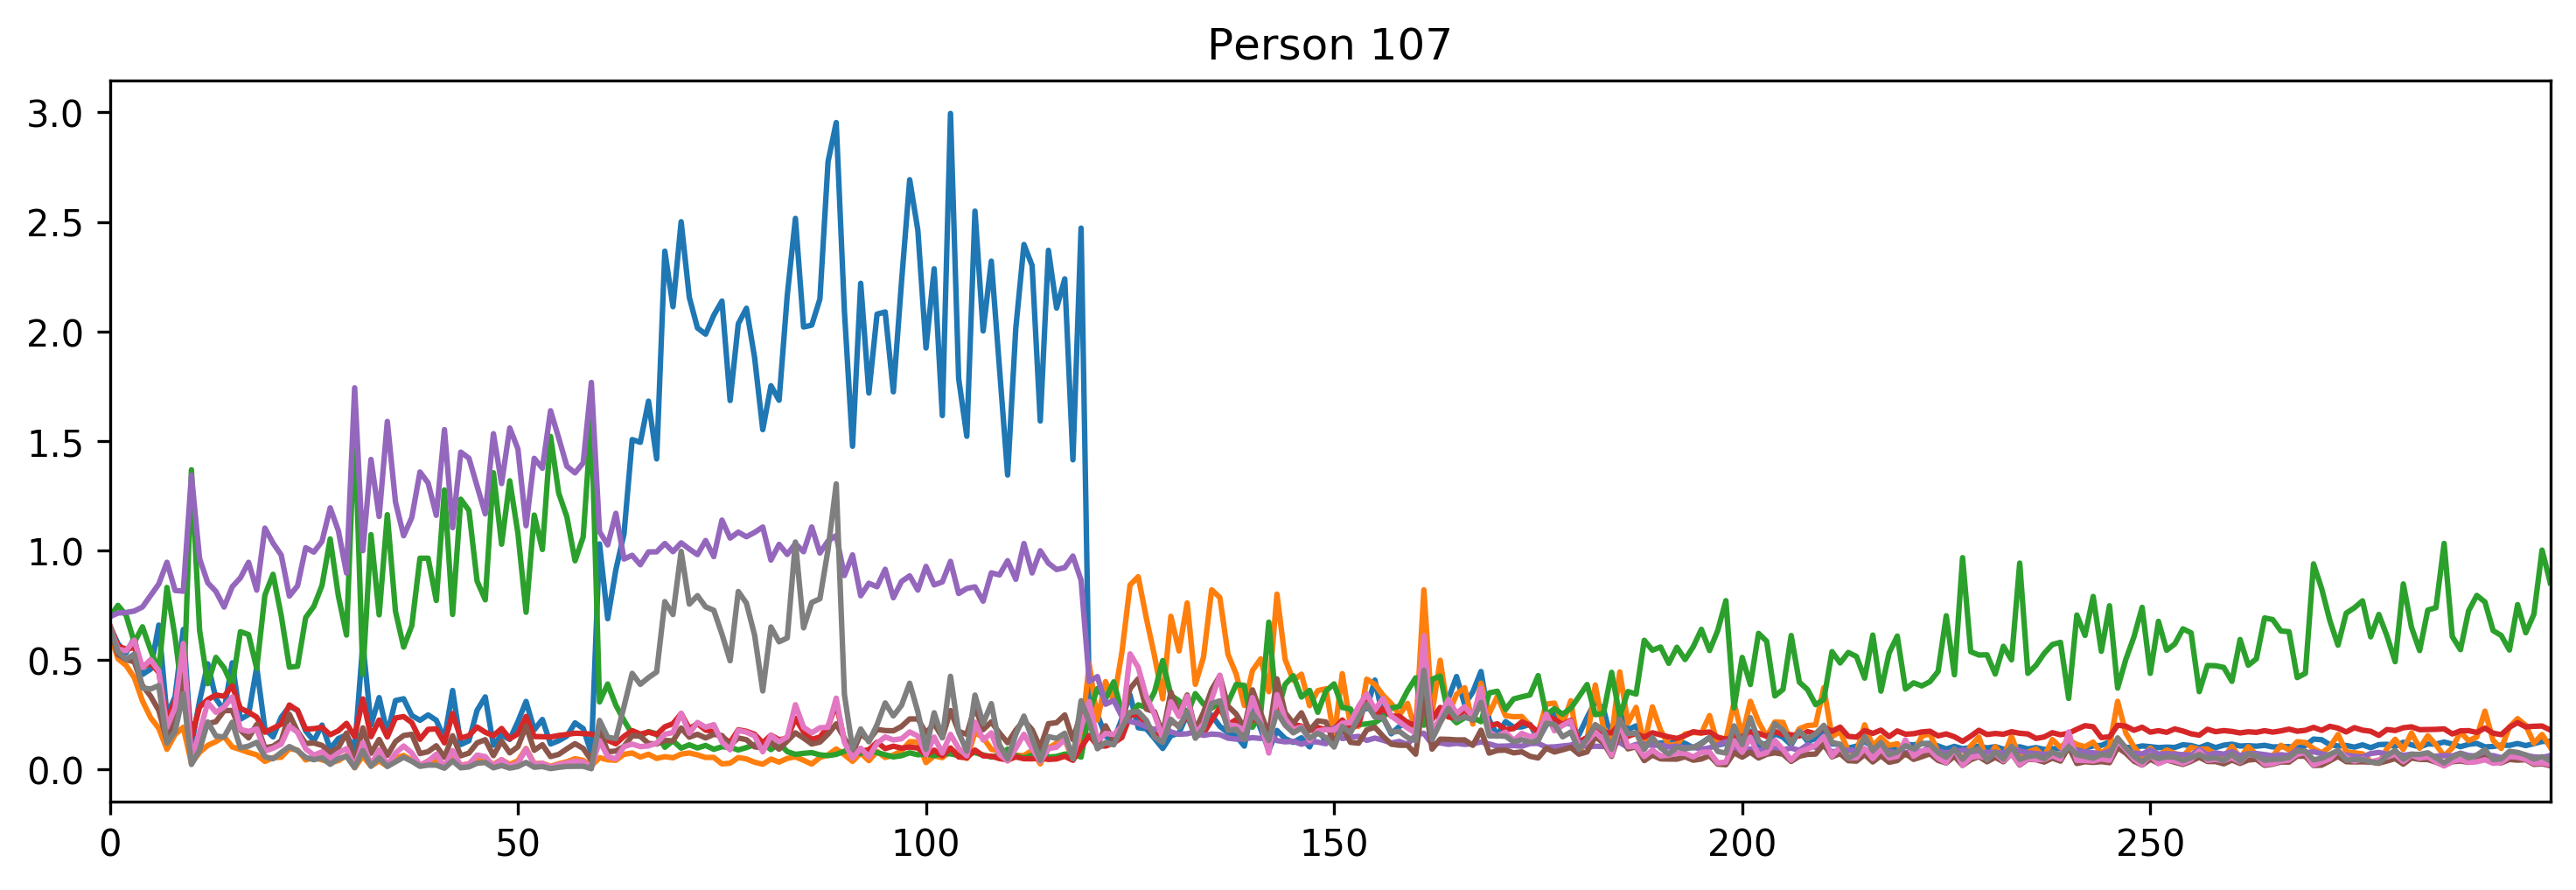

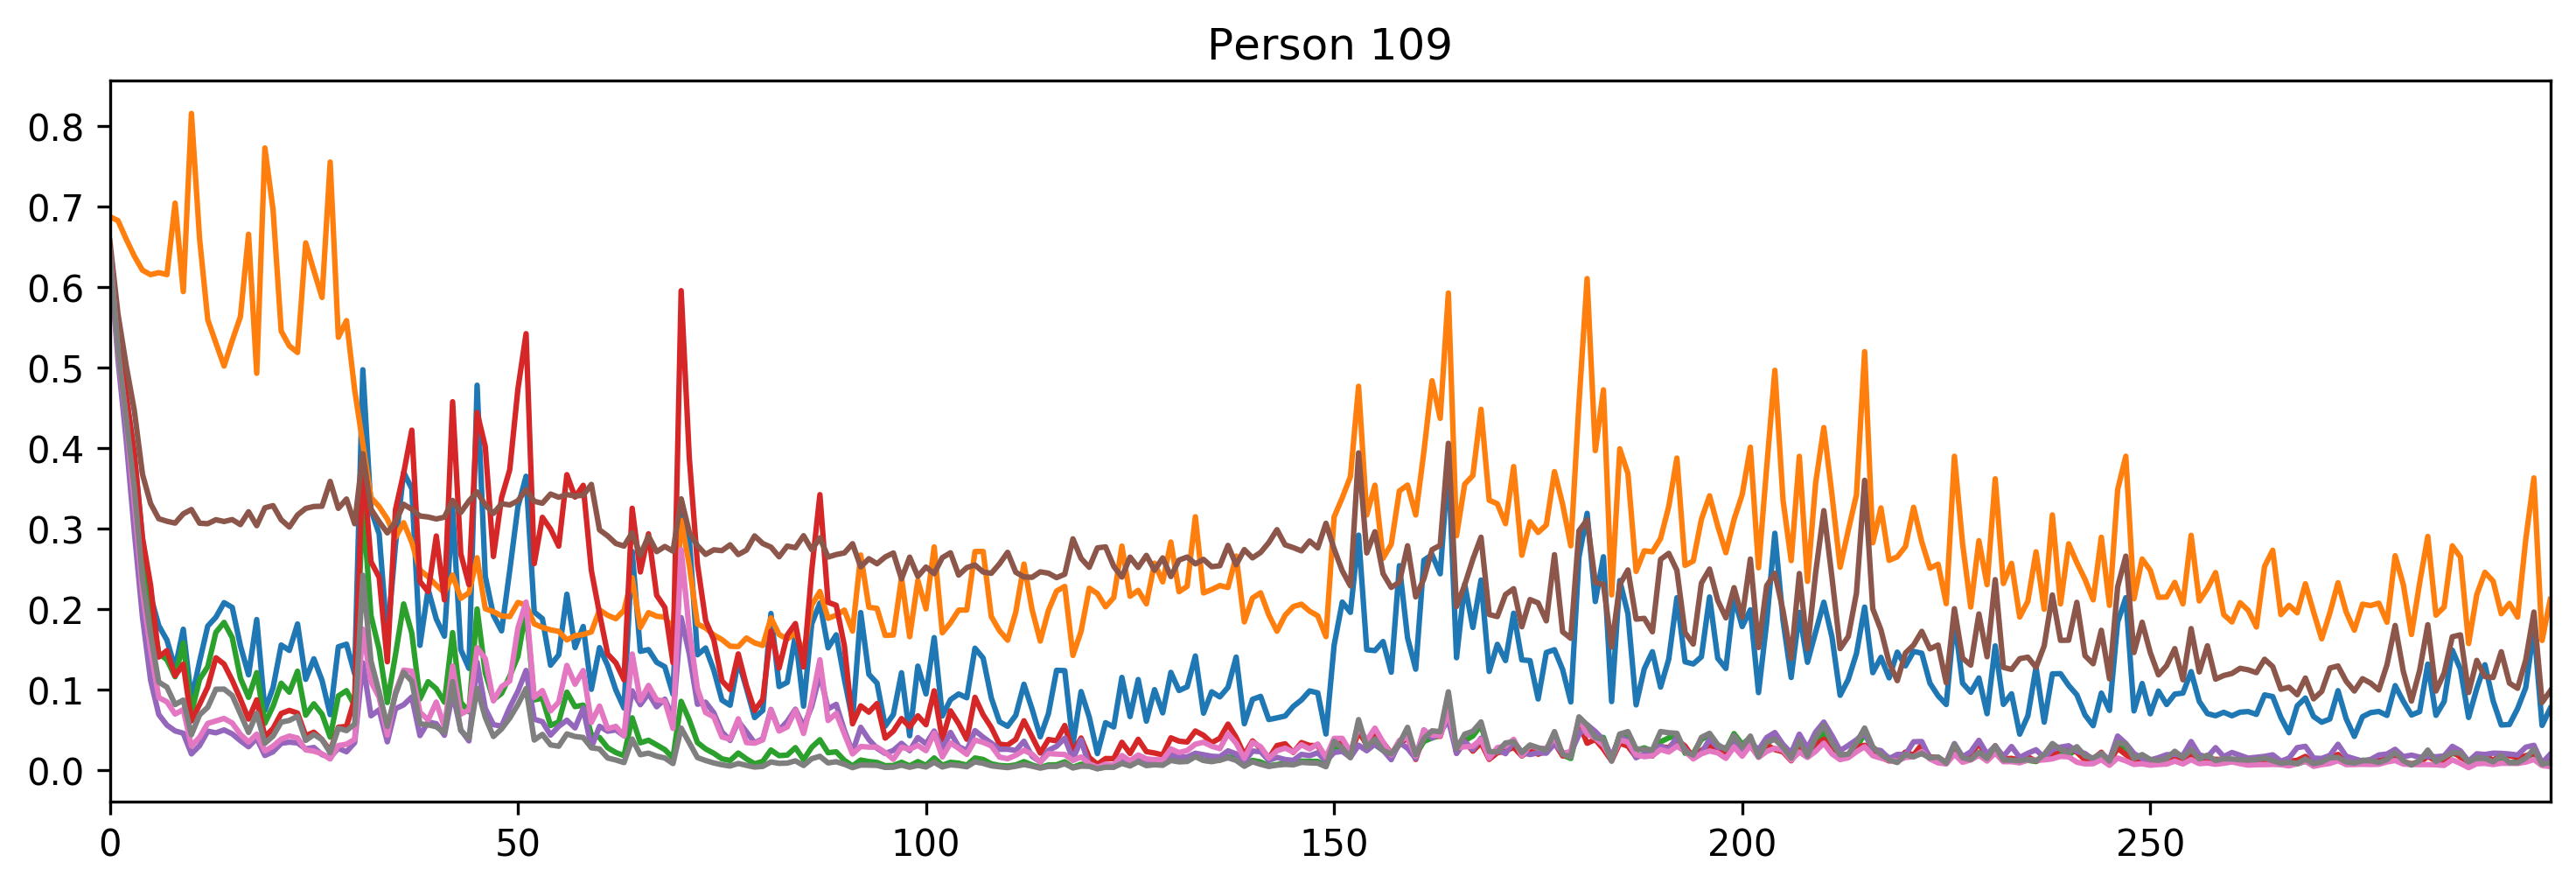

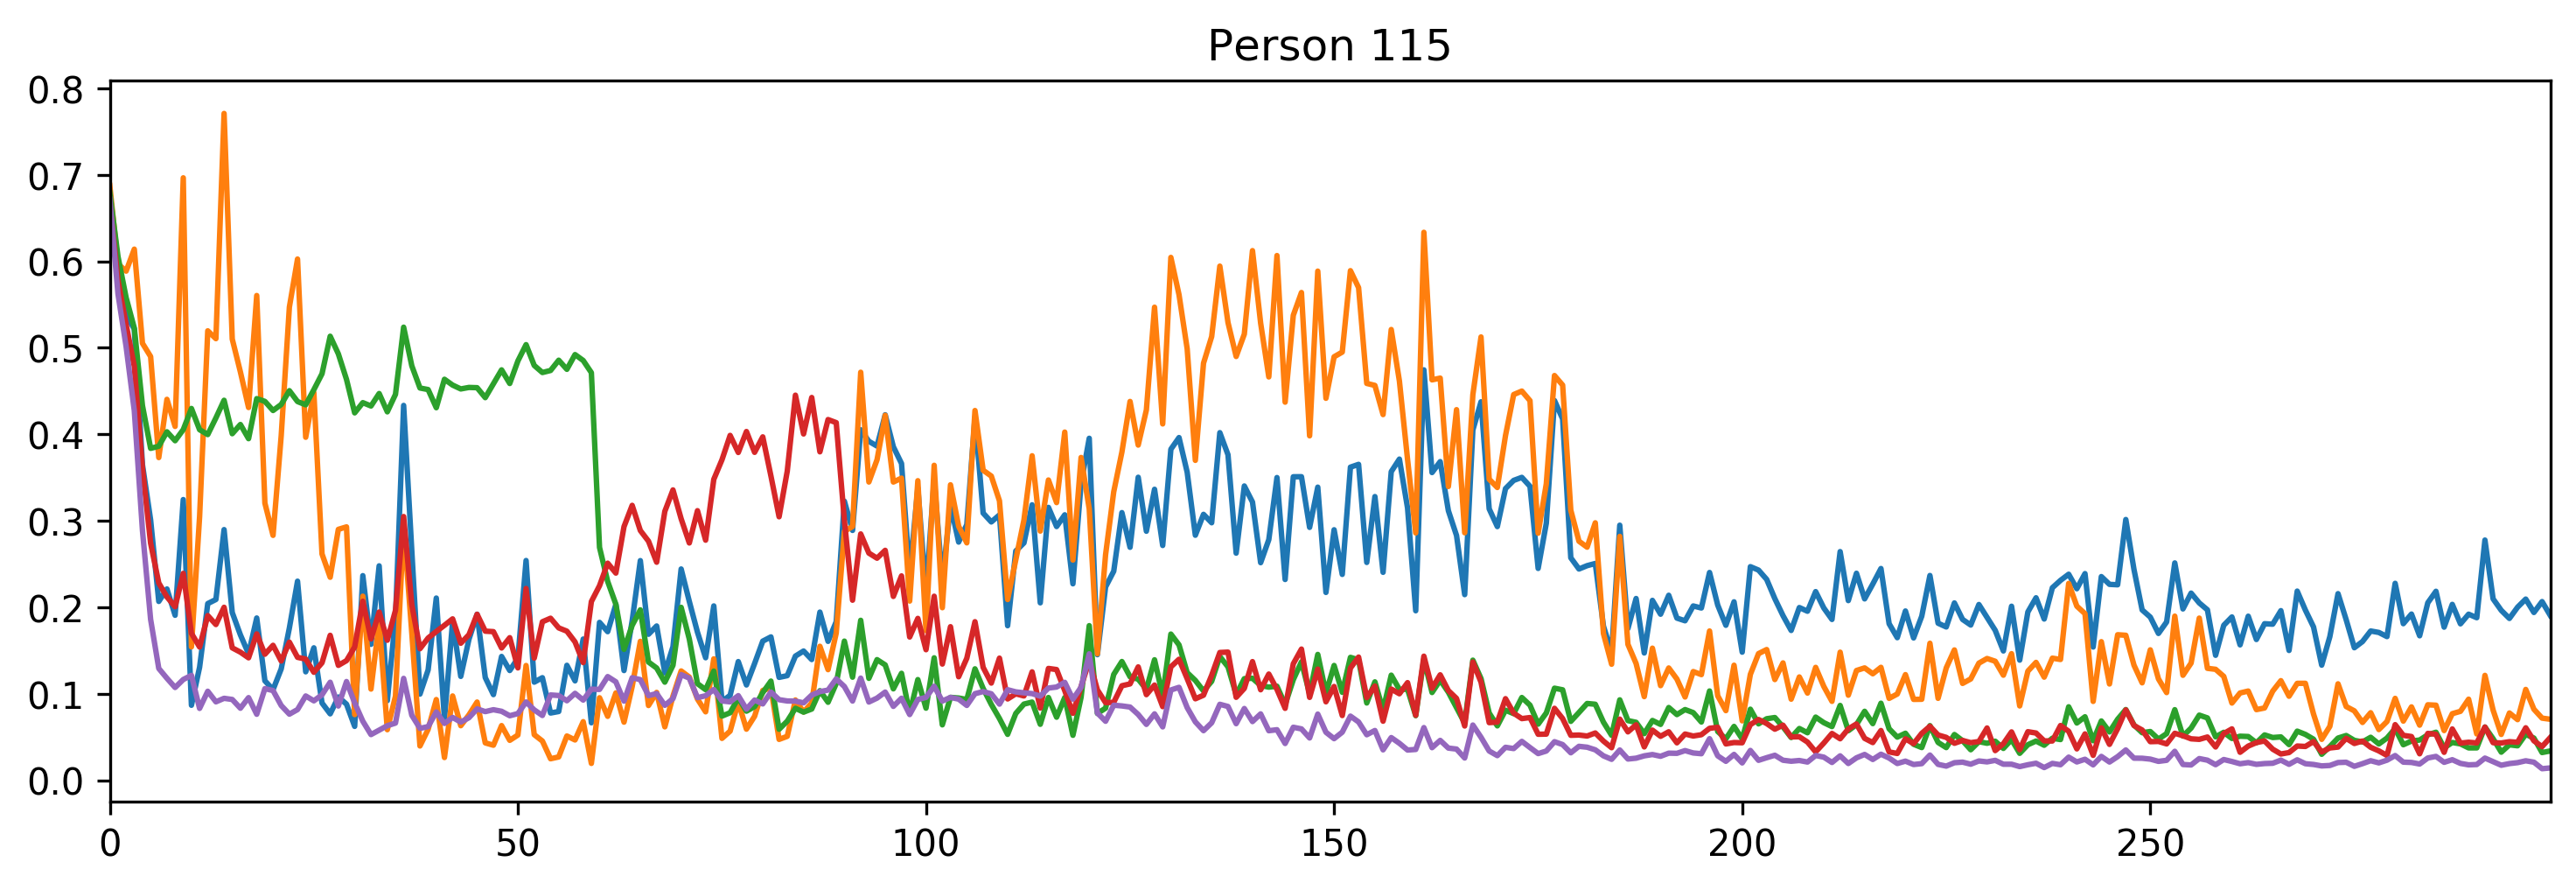

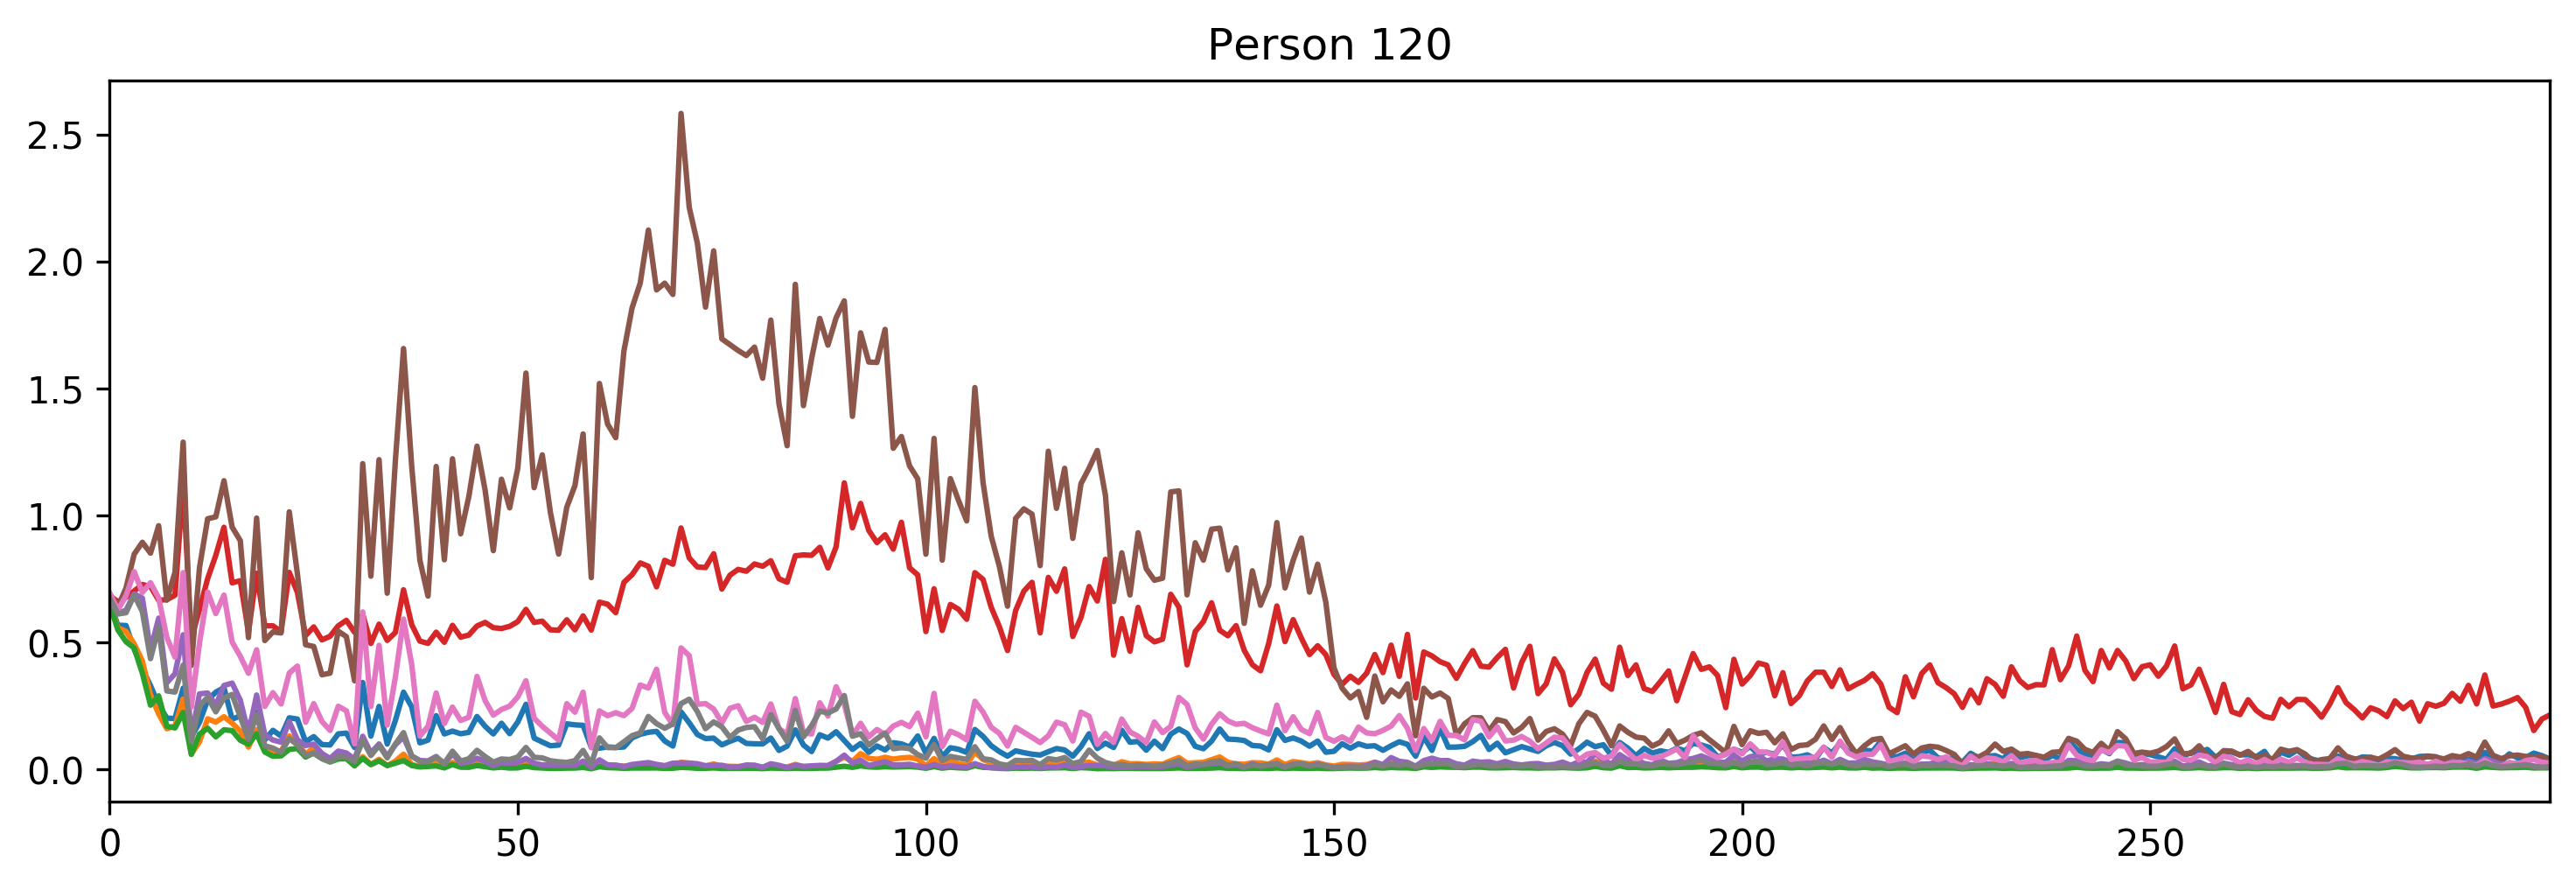

In [7]:
for person, df_person in df.groupby('Person'):
    fig = plt.figure(dpi=300, figsize=(12, 8))
    for session, df_session in df_person.groupby('Session'):
        df_session.reset_index()['Loss'].plot(ax=fig.add_subplot(2, 1, 1), title='Person {}'.format(int(person)))

### Step 3.1: Draw Aggregate plot

In [ ]:
metric = 'Aggregate ' + current_metric

In [ ]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 18, 
                     'font.family' : 'arial', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 22})

# Draw Aggregate Plot
columns = ['Shard', 'Epoch', 'Loss', 'Aggregate Avg. Precision', 'Aggregate Accuracy', 
            'Aggregate Precision', 'Aggregate Recall', 'Aggregate F1_Score']

colors = ['#00065E', '#266DC9', '#F3752B', '#F02D3A', '#A20021']
line_style = ['--', '--', '-', '-', '-']

# Draw metrics
folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
for idx, folder in enumerate(folders):
    df_concat = pd.DataFrame(columns=columns)
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            file = os.path.join(folder, file)
            df = pd.read_csv(file, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df = df[columns]
            df_concat = pd.concat((df_concat, df), ignore_index=True)
            df_concat.drop_duplicates(inplace=True)
    df_concat.reset_index(inplace=True)
    ax = df_concat[metric].plot(figsize=(24, 16), color=colors[idx], linewidth=1, linestyle=line_style[idx])

# Draw VLines
for i, file in enumerate(sorted(os.listdir(folders[0]))):
    ax.axvline(i * (df_concat['Epoch'].max() + 1), color='#C0C0C0', linestyle='dashed', label='_nolegend_')
    shard = float(file.split('_shard-')[1].split('_')[0])
    shard_text = "Shard: {:.0%}".format(shard) if "sessions" not in file else "Session: {}".format(int(shard)+1)
    plt.text(i * (df_concat['Epoch'].max() + 1) + 1, 0.02, shard_text)

# Draw Baselines
# baseline_folders = sorted([folder for folder in final_results_folders if 'Baseline' in folder])
# h_colors =['#002BA0', '#DD0426']
# h_line_style = ['--', '-']
# for idx, folder in enumerate(baseline_folders):
#     for file in os.listdir(folder):
#         file = os.path.join(folder, file)
#         df = pd.read_csv(file, index_col=0)
#         ax.axhline(df[metric].iloc[0], color=h_colors[idx], linestyle=h_line_style[idx])


# Set plot parameters
folders.extend(baseline_folders)
ax.legend([folder.split('PAIN_')[1] for folder in folders], loc='best')
ax.set_title("{} | All Experiments".format(metric))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in np.arange(0,1.1,0.1)])
ax.set_ylabel(metric)
ax.set_xlabel('Epochs / Communication Rounds')

In [ ]:
# Save figure
fig_path = os.path.join(FIGURES, 'Final', data_type)
file = os.path.join(fig_path, metric + '.png')
fig = ax.get_figure()
fig.savefig(file, dpi=300)

### Step 3.2 Individual Standard Deviation

In [ ]:
# Specify Metrics
current_metric = "F1-Score" if current_metric == "F1_Score" else current_metric
metric = 'Individual ' + current_metric

In [ ]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 18, 
                     'font.family' : 'arial', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 22})

# Draw standard deviation
columns = ['Shard', 'Epoch', 'Person', 'Loss', 'Individual Avg. Precision', 'Individual Accuracy', 
            'Individual Precision', 'Individual Recall', 'Individual F1-Score']

colors = ['#00065E', '#266DC9', '#F3752B', '#F02D3A', '#A20021']
line_style = ['--', '--', '-', '-', '-']

# Plot standard deviations
folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
for idx, folder in enumerate(folders):
    df_concat = None
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            file = os.path.join(folder, file)
            df = pd.read_csv(file, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df = df[columns]
            df['Person'] = df['Person'].astype(int)
            pivot = df.pivot(index='Epoch', columns='Person', values=metric)
            if df_concat is None:
                df_concat = pd.DataFrame(columns=pivot.columns)
            df_concat = pd.concat((df_concat, pivot), ignore_index=True)
    df_concat['Mean'] = df_concat.mean(axis=1)
    df_concat['SD'] = df_concat.std(axis=1)
    ax = df_concat['SD'].plot(figsize=(24, 16), color=colors[idx], linewidth=1, linestyle=line_style[idx])
    
for i, file in enumerate(sorted(os.listdir(folders[0]))):
    ax.axvline(i * int(len(df_concat) / len(os.listdir(folders[0]))), color='#C0C0C0', linestyle='dashed', label='_nolegend_')
    shard = float(file.split('_shard-')[1].split('_')[0])
    shard_text = "Shard: {:.0%}".format(shard) if "sessions" not in file else "Session: {}".format(int(shard)+1)
    plt.text(i * int(len(df_concat) / len(os.listdir(folders[0]))) + 1, 0.005, shard_text)
    
ax.legend([folder.split('PAIN_')[1] for folder in folders], loc='best')
ax.set_title("{} | Standard deviation between subjects | All Experiments".format(metric))
ax.set_yticks(np.arange(0, 0.5, 0.1))
ax.set_ylabel('Standard deviation between subjects')
ax.set_xlabel('Epochs / Communication Rounds')
metric = 'SD_' + metric

In [ ]:
# Save figure
fig_path = os.path.join(FIGURES, 'Final', data_type)
file = os.path.join(fig_path, metric + '.png')
fig = ax.get_figure()
fig.savefig(file, dpi=300)

### Step 3.3 Individual metrics

In [ ]:
# Specify Metrics
current_metric = "F1-Score" if current_metric == "F1_Score" else current_metric
metric = 'Individual ' + current_metric

In [ ]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 12, 
                     'font.family' : 'arial', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 14})

# Draw individual metrics
columns = ['Shard', 'Epoch', 'Person', 'Loss', 'Individual Avg. Precision', 'Individual Accuracy', 
            'Individual Precision', 'Individual Recall', 'Individual F1-Score']

colors = ['#00065E', '#266DC9', '#F3752B', '#F02D3A', '#A20021']
line_style = ['--', '--', '-', '-', '-']

# Plot standard deviations
fig = plt.figure(dpi=300, figsize=(48, 60))
folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
for idx, folder in enumerate(folders):
    df_concat = None
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            file = os.path.join(folder, file)
            df = pd.read_csv(file, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df = df[columns]
            df['Person'] = df['Person'].astype(int)
            pivot = df.pivot(index='Epoch', columns='Person', values=metric)
            if df_concat is None:
                df_concat = pd.DataFrame(columns=pivot.columns)
            df_concat = pd.concat((df_concat, pivot), ignore_index=True)
    ax = df_concat.plot(figsize=(24, 20), linewidth=1, ax=fig.add_subplot(3, 2, idx+1))
    
    for i, file in enumerate(sorted(os.listdir(folders[0]))):
        ax.axvline(i * int(len(df_concat) / len(os.listdir(folders[0]))), color='#C0C0C0', linestyle='dashed', label='_nolegend_')
        shard = float(file.split('_shard-')[1].split('_')[0])
        shard_text = "Shard: {:.0%}".format(shard) if "sessions" not in file else "Session: {}".format(int(shard)+1)
        plt.text(i * int(len(df_concat) / len(os.listdir(folders[0]))) + 1, 0.005, shard_text)
    
    ax.legend(loc='best', title='Test Subject')
    ax.set_title("{}".format(folder.split('PAIN_')[1]))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in np.arange(0,1.1,0.1)])
    ax.set_ylabel(metric)
    ax.set_xlabel('Epochs / Communication Rounds')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(metric, fontsize=20)
plt.show()

In [ ]:
# Save figure
fig_path = os.path.join(FIGURES, 'Final', data_type)
file = os.path.join(fig_path, metric + '.png')
fig = ax.get_figure()
fig.savefig(file, dpi=300)

### Step 3.4 Individual Metrics - Final Epoch

In [ ]:
# Specify Metrics
current_metric = "F1-Score" if current_metric == "F1_Score" else current_metric
metric = 'Individual ' + current_metric

In [ ]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 12, 
                     'font.family' : 'arial', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 14})

# Draw individual metrics
columns = ['Shard', 'Epoch', 'Person', 'Loss', 'Individual Avg. Precision', 'Individual Accuracy', 
            'Individual Precision', 'Individual Recall', 'Individual F1-Score']

colors = ['#00065E', '#266DC9', '#F3752B', '#F02D3A', '#A20021']
line_style = ['--', '--', '-', '-', '-']

# Plot standard deviations
fig = plt.figure(dpi=300, figsize=(48, 60))
folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
for idx, folder in enumerate(folders):
    df_concat = None
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            file = os.path.join(folder, file)
            df = pd.read_csv(file, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df = df[columns]
            df['Person'] = df['Person'].astype(int)
            df = df[df['Epoch'] == df['Epoch'].max()]
            if df_concat is None:
                df_concat = pd.DataFrame(columns=df.columns)
            df_concat = pd.concat((df_concat, df), ignore_index=True)
    pivot = df_concat.pivot(index='Shard', columns='Person', values=metric)
    ax = pivot.plot(figsize=(24, 20), linewidth=1, ax=fig.add_subplot(3, 2, idx+1))
    ax.legend(loc='best', title='Test Subject')
    ax.set_title("{}".format(folder.split('PAIN_')[1]))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in np.arange(0,1.1,0.1)])
    ax.set_ylabel(metric)
    ax.set_xticks(pivot.index)
    x_tick_format = '{:,.0%}' if "sessions" not in file else "{:.0f}"
    ax.set_xticklabels([x_tick_format.format(x) for x in pivot.index])
    xlabel = "Shard" if "sessions" not in file else "Sessions"
    ax.set_xlabel(xlabel)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Last Epoch Value: " + metric, fontsize=20)
plt.show()

In [ ]:
# Save figure
fig_path = os.path.join(FIGURES, 'Final', data_type)
file = os.path.join(fig_path, "Last Epoch " + metric + '.png')
fig = ax.get_figure()
fig.savefig(file, dpi=300)

### Plot Session Accuracy

In [ ]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 18, 
                     'font.family' : 'arial', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 22})

# Draw Aggregate Plot
columns = ['Shard', 'Epoch', 'Aggregate Accuracy', 
            'Aggregate Precision', 'Aggregate Recall', 'Aggregate F1_Score']

colors = ['#00065E', '#266DC9', '#F3752B', '#F02D3A', '#A20021']
line_style = ['--', '--', '-', '-', '-']

# Draw metrics
folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
for idx, folder in enumerate([folders[1]]):
    df_concat = pd.DataFrame(columns=columns)
    for idx, file in enumerate(sorted(os.listdir(folder))):
        if 'shard-0.00' not in file:
            file = os.path.join(folder, file)
            df = pd.read_csv(file, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df = df[columns]
            df.drop_duplicates(inplace=True)
            df.reset_index(inplace=True)
            ax = df[metric].plot(figsize=(24, 16), linewidth=1)
            
# Draw VLines
for i, file in enumerate(sorted(os.listdir(folders[0]))):
    ax.axvline(i * (df_concat['Epoch'].max() + 1), color='#C0C0C0', linestyle='dashed', label='_nolegend_')
    shard = float(file.split('_shard-')[1].split('_')[0])
    shard_text = "Shard: {:.0%}".format(shard) if "sessions" not in file else "Session: {}".format(int(shard)+1)
    plt.text(i * (df_concat['Epoch'].max() + 1) + 1, 0.02, shard_text)

# Draw Baselines
# baseline_folders = sorted([folder for folder in final_results_folders if 'Baseline' in folder])
# h_colors =['#002BA0', '#DD0426']
# h_line_style = ['--', '-']
# for idx, folder in enumerate(baseline_folders):
#     for file in os.listdir(folder):
#         file = os.path.join(folder, file)
#         df = pd.read_csv(file, index_col=0)
#         ax.axhline(df[metric].iloc[0], color=h_colors[idx], linestyle=h_line_style[idx])


# Set plot parameters
folders.extend(baseline_folders)
ax.legend([folder.split('PAIN_')[1] for folder in folders], loc='best')
ax.set_title("{} | All Experiments".format(metric))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in np.arange(0,1.1,0.1)])
ax.set_ylabel(metric)
ax.set_xlabel('Epochs / Communication Rounds')
            

In [ ]:
df

## Step 4: Sumarize data

### Step 4.1: DataFrame Summary

In [ ]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.render()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [ ]:
# Display Data in Dataframe
metrics = ['Individual Accuracy', 'Individual Precision', 'Individual Recall', 'Individual F1-Score']
display_type = 'single'

folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
for idx, folder in enumerate(folders):
    df_concat = None
    pivots = []
    print("\n\n\033[1m{}\033[0m".format(folder.split('PAIN_')[1]))
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            file = os.path.join(folder, file)
            df = pd.read_csv(file, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df['Person'] = df['Person'].astype(int)
            if df_concat is None:
                df_concat = pd.DataFrame(columns=df.columns)
            df_concat = pd.concat((df_concat, df), ignore_index=True)
            df_concat.drop_duplicates(inplace=True)
    df_concat.reset_index(inplace=True)
    for metric in metrics:
        columns = 'Shard'
        index = 'Person'
        df_filtered = df_concat[df_concat['Epoch'] == df_concat['Epoch'].max()]
        pivot = df_filtered[[index, columns, metric]].drop_duplicates().pivot(index=index, columns=columns, values=metric)
        cm = sns.diverging_palette(10, 130, n=9, as_cmap=True)
        style = pivot.style.background_gradient(cmap=cm).format('{:,.0%}').set_caption(metric)
        pivots.append(style)
    display_side_by_side(pivots[0], pivots[1])
    display_side_by_side(pivots[2], pivots[3])

### Step 4.2 Table Summary Aggregate

In [ ]:
current_metric = 'Accuracy'
metric = 'Aggregate ' + current_metric

In [ ]:
# Save concatenated pivot to excel
plt.rcParams.update({'font.size': 12, 
                     'font.family' : 'arial', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 16})

# Draw Aggregate Table
columns = ['Shard', 'Epoch', 'Loss', 'Session', 'Aggregate Avg. Precision', 'Aggregate Accuracy', 
            'Aggregate Precision', 'Aggregate Recall', 'Aggregate F1_Score']

folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
piv_conc = None
for j, folder in enumerate(folders):
    df_concat = None
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            f_path = os.path.join(folder, file)
            df = pd.read_csv(f_path, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df = df[columns]
            if df_concat is None:
                df_concat = pd.DataFrame(columns=df.columns)
            df_concat = pd.concat((df_concat, df), ignore_index=True)
            df_concat.drop_duplicates(inplace=True)
    df_concat = df_concat[df_concat['Epoch'] == 29]

    pivot = df_concat.pivot(index='Shard', columns='Session', values=metric)   
    pivot['Mean'] = pivot.mean(axis=1)
    pivot = pivot.fillna(0)
    if piv_conc is None:
        piv_conc = pd.DataFrame(columns=pivot.columns)
    piv_conc = pd.concat((piv_conc, pivot))
piv_conc.to_excel(os.path.join(FIGURES, 'Final', data_type, "Sessions Table " + metric + '.xlsx'))

### Step 4.3 Table Summary Individual

In [ ]:
current_metric = 'Avg. Precision'
metric = 'Individual ' + current_metric

In [ ]:
# Save concatenated pivot to excel
plt.rcParams.update({'font.size': 12, 
                     'font.family' : 'arial', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 16})

# Draw Aggregate Table
columns = ['Shard', 'Epoch', 'Loss', 'Person', 'Session', 'Individual Avg. Precision', 'Individual Accuracy', 
            'Individual Precision', 'Individual Recall', 'Individual F1-Score']

folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
pivot_concat = None
for j, folder in enumerate(folders):
    df_concat = None
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            f_path = os.path.join(folder, file)
            df = pd.read_csv(f_path, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df = df[columns]
            if df_concat is None:
                df_concat = pd.DataFrame(columns=df.columns)
            df_concat = pd.concat((df_concat, df), ignore_index=True)
            df_concat.drop_duplicates(inplace=True)
    df_concat = df_concat[df_concat['Epoch'] == df_concat['Epoch'].max()]
    df_concat['Shard'] = df_concat['Shard'].astype(int)
    for person, df_person in df_concat.groupby('Person'):
        pivot = df_person.pivot(index="Shard", columns="Session", values=metric)
        pivot['Test Subject'] = person
        if pivot_concat is None:
            pivot_concat = pd.DataFrame(columns=[0,1,2,3,4,5,6,7,8,9, 'Test Subject'])
        pivot_concat = pd.concat((pivot_concat, pivot), sort=False)
    
# Add Baseline
baseline_folders = sorted([folder for folder in final_results_folders if 'Baseline' in folder])
pivot_baseline = None
for idx, folder in enumerate(baseline_folders):
    for file in os.listdir(folder):
        if os.path.splitext(file)[1] == '.csv':
            f_path = os.path.join(folder, file)
            df = pd.read_csv(f_path, index_col=0)
            for person, df_person in df.groupby('Person'):
                pivot = df_person.pivot(index="Shard", columns="Session", values=metric)
                pivot['Test Subject'] = person
                if pivot_baseline is None:
                    pivot_baseline = pd.DataFrame(columns=[0,1,2,3,4,5,6,7,8,9, 'Test Subject'])
                pivot_baseline = pd.concat((pivot_baseline, pivot), sort=False)
pivot_concat = pd.concat((pivot_concat, pivot_baseline), sort=False)
pivot_concat.to_excel(os.path.join(FIGURES, 'Final', data_type, "Feeder Table", "Sessions Table " + metric + '.xlsx'))

### Step 4.4: Session Data Summary

In [5]:
group_2 = DL.get_image_paths(os.path.join(DATA, 'group_2'))
labels = np.array(DL.get_labels(group_2))
columns = ['Person', 'Session', 'Culture', 'Frame', 'Pain', 'Trans_1', 'Trans_2']
df = pd.DataFrame(labels, columns=columns)
df[['Person', 'Session', 'Culture', 'Frame', 'Pain']] = df[['Person', 'Session', 'Culture', 'Frame', 'Pain']].astype(int)

In [6]:
def create_pivot(index, columns, values):
    pivot = ~df[['Person', 'Session']].drop_duplicates().pivot(index=index, columns=columns, values=values).isnull() * 1
    pivot['# of ' + columns + 's'] = pivot.sum(1)
    pivot = pivot.sort_values('# of ' + columns + 's', ascending=False)
    
    pivot['Pain'] = 0
    pivot['No Pain'] = 0
    for person, df_person in df.groupby(index):
        pivot.at[person, 'No Pain'] = sum(df_person['Pain'] == 0)
        pivot.at[person, 'Pain'] = sum(df_person['Pain'] > 0)
        for col in pivot.columns:
            if type(col) is int:
                pivot.at[person, col] = sum(df_person[df_person[columns] == col]['Pain'] > 0)
                
    if columns is 'Session':
        for col in reversed(pivot.columns):
            if type(col) is int:
                pivot.rename(columns={col:col+1}, inplace=True)
    if index is 'Session':
        for idx in reversed(pivot.index):
            pivot.rename(index={idx:idx+1}, inplace=True)
    pivot = pivot.append(pivot.sum(0).rename("Total"))
    pivot['Pain %'] = round(pivot['Pain'] / (pivot['Pain'] + pivot['No Pain']), 2)
    pivot[pivot == 0] = ''
    return pivot

In [7]:
index='Person'
columns='Session'
values=columns
df = create_pivot(index, columns, values)

In [8]:
df

Session     1     2     3    4     5     6    7 8    9   10  # of Sessions  \
Person                                                                       
52         72                                44    120  188             10   
43        140                    228                                     9   
96                               112        512     88                   9   
107        32         848   60   828                                     8   
109             600                    116                               8   
120       116              188                                           8   
48              148                    188                               7   
80       1052   536   484  484   660   792  264                          7   
64        244    64    64        248                                     6   
92        464   696              724                                     5   
115        60         220   56    60                                     5   
59              532                                                      2   
Total    2180  2576  1616  788  2860  1096  820    208  188             84   

Session   Pain  No Pain  Pain %  
Person                           
52         424    10012    0.04  
43         368     4112    0.08  
96         712     8700    0.08  
107       1768     6396    0.22  
109        716     6896    0.09  
120        304     5960    0.05  
48         336     3192    0.10  
80        4272     3584    0.54  
64         620     5576    0.10  
92        1884     4124    0.31  
115        396     4736    0.08  
59         532     2560    0.17  
Total    12332    65848    0.16

In [ ]:
index='Session'
columns='Person'
values=columns
create_pivot(index, columns, values)

In [ ]:
final_results_folders = [folder for folder in final_results_folders if criteria in folder and date in folder]

In [ ]:
df_concat = None

folder = final_results_folders[3]
for file in os.listdir(folder):
    if "shard-0.00" not in file:
        f_path = os.path.join(folder, file)
        df = pd.read_csv(f_path)
        df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
        if df_concat is None:
            df_concat = pd.DataFrame(columns=df.columns)
        df_concat = pd.concat((df_concat, df))

In [ ]:
df_session = None
for sess, df in df_concat.groupby('Session'):
    df_this = pd.DataFrame(columns=df.columns, data=df.values)
    tn_g = df_this.groupby('Epoch')['TN'].transform(sum)
    fp_g = df_this.groupby('Epoch')['FP'].transform(sum)
    fn_g = df_this.groupby('Epoch')['FN'].transform(sum)
    tp_g = df_this.groupby('Epoch')['TP'].transform(sum)
    df_this['Aggregate Accuracy'] = (tp_g + tn_g) / (tn_g + fp_g + fn_g + tp_g)
    df_this['Aggregate Precision'] = tp_g / (fp_g + tp_g)
    df_this['Aggregate Recall'] = tp_g / (fn_g + tp_g)
    df_this['Aggregate F1_Score'] = 2 * ((df_this['Aggregate Precision'] * df_this['Aggregate Recall']) / (
            df_this['Aggregate Precision'] + df_this['Aggregate Recall']))
    if df_session is None:
        df_session = pd.DataFrame(columns=df_this.columns)
    df_session = pd.concat((df_session, df_this), ignore_index=True)

In [ ]:
df=pd.DataFrame(columns=['Session'])

In [ ]:
df['Session'] <=-1